In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
#from specutils.fitting import find_lines_threshold, find_lines_derivative
#from scipy.optimize import curve_fit
#from astropy.stats import sigma_clip
from glob import glob
from scipy.signal import find_peaks
from specutils.manipulation import LinearInterpolatedResampler

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [2]:
spectrum_files = glob(os.path.join('HST','anonymous37222', '*.fits'))

In [193]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [194]:
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [ ]:
INST_head = [fits.getheader(file, ext=0) for file in spectrum_files]
SCI_head = [fits.getheader(file, ext=1) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [50]:
#date = [header['DATE-OBS'] for header in spectrum_header]
#observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header_0]
#instrument_filter = [header['OPT_ELEM'] for header in spectrum_header_0]

In [ ]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
#lab_emission_lines = lines['lab_lambda']
#transition_grouped_lines = lines.groupby("[nu', J']")

In [ ]:
spectrum_x1d[0]

In [ ]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
#wavesort_idx = np.argsort(x1d_wavelength)
#x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

#x1d_flux = x1d_flux[wavesort_idx]
#x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [ ]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [ ]:
peaks , _ = find_peaks(np.array(x1d_flux), height=max(x1d_fluxerr.value)*2, distance=100)

In [ ]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [ ]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

In [ ]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [ ]:
line_width = 150
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]

In [ ]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [ ]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = x1d_h2_emissions_flux
fluxerr = x1d_h2_emissions_fluxerr
wavelength = x1d_h2_emissions_wavelength

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)

In [ ]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

In [ ]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function

In [7]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=False)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
#plt.rcParams['figure.dpi'] = 300

In [23]:
#Keep units for future math
class spectrum():
    def __init__(self, files, linelist_file):
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = None
        self.linelist = pd.read_csv(linelist_file, skiprows=2)
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)
            
            self.x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            self.x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            self.x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            if "cspec" in file:
                date = SCI_head['DATE-BEG'][:10]
            elif "x1dsum" in file:
                date = SCI_head['DATE-OBS']
            instrument = INST_head['INSTRUME']
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header
            df_data = {'filename':file, 
                       'obsdate':date,
                       'instrument':instrument, 
                       'filter':instrument_filter, 
                       'wavelength':self.x1d_wavelength*self.wavelength_units, 
                       'flux': self.x1d_flux*self.flux_units, 
                       'fluxerr':self.x1d_fluxerr*self.flux_units}
            rows.append(pd.Series(df_data))
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)
        self.spec_df['obsdate'] = self.spec_df['obsdate'].astype(str)

    def coaddwave(self, df, columns=['obsdate'], velocity=False):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - df: The dataframe to use for co-adding. Must contain 'wavelength', 
              'flux', and 'fluxerr' columns at least. If using velocity_space, must contain 'rest_wavelength' column.
        - columns: the columns of unique combinations to apply coadding to.

        Returns:
        - coadded_spectrum: spectrum dataframe
        """
        res = {}
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]

            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]

            resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
            wavelengths = group['wavelength'].values
            fluxes = group['flux'].values
            fluxerrs = group['fluxerr'].values
            if velocity:
                lablines = group['labline'].values
            base_wave = wavelengths[0]
            spectra = []

            for i in range(len(wavelengths)):#wave, flux, err in zip(wavelengths, fluxes, fluxerrs):
                wave = wavelengths[i]
                flux = fluxes[i]
                err = fluxerrs[i]
                wavesort_idx = np.argsort(wave)
                spec = Spectrum1D(spectral_axis=wave[wavesort_idx], 
                                    flux=flux[wavesort_idx], 
                                    uncertainty=StdDevUncertainty(err[wavesort_idx]))
                wavespec_resampled = resampler(spec, np.sort(base_wave))
                spectra.append(wavespec_resampled)

            coadded = np.sum(spectra)
            
            coadd_wave = coadded.wavelength
            coadd_flux = coadded.flux
            coadd_err = coadded.uncertainty.quantity.to(self.flux_units)
            if velocity:
                coadd_vel = (coadd_wave - lablines[0]*u.AA)/(lablines[0]*u.AA) * const.c.to(u.km/u.s)
                spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err, 'velocity': coadd_vel}
            else:
                spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err}
            res[tuple(unique_values)] = spec_dict

        stacked_df = pd.DataFrame([
            {**dict(zip(columns, k)), **(v if v is not None else {})}
            for k, v in res.items()
        ])

        return stacked_df
    
    def H2lines_fromspectrum(self, df):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = None
        df["[nu', J']"] = None
        df["rest_wavelength"] = None
        for i in range(len(df)):
            row = df.iloc[i]
            peaks , _ = find_peaks(np.array(row['flux'].value), height=np.array(row['fluxerr'].value)*2, distance=50)
            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = []
            nu_J = []
            lab_lines = []
            if len(peaks)>=0.5:
                for il, l in enumerate(self.linelist['lab_lambda']):
                    diff = abs(row['wavelength'][peaks]/u.AA-l)
                    if min(diff) <= 2:
                        emission_table_idx.append(np.argmin(diff))
                        nu_J.append(self.linelist['[nu\', J\']'].iloc[il])
                        lab_lines.append(l)
            else:
                pass
            
            for il, l in enumerate(self.linelist['lab_lambda'].values):
                wavelength = row['wavelength']/u.AA
                diffs = np.abs(wavelength-l)

                mask = diffs <= 0.5

                if np.any(mask):
                    min_idx = np.argmin(diffs)
                    emission_table_idx.append(min_idx)
                    nu_J.append(self.linelist.loc[il, '[nu\', J\']'])
                    lab_lines.append(l)
            df.at[i, 'H2line_idx'] = np.array(emission_table_idx)
            df.at[i, "[nu', J']"] = nu_J
            df.at[i, 'rest_wavelength'] = lab_lines
        return df

    def radial_velocity(self, wavelengths, central_wave, labline):
        # once I have coadded wavelengths, I want to convert the wavelengths to velocity
        # I need the wavelength, and the labline
        velocity = (wavelengths - central_wave)/(labline*u.AA) * const.c.to(u.AA/u.s)
        return velocity
    
    def get_lines(self, df):
        line_width = 150 #150 points on either side of the central line
        transitions = set(self.linelist['[nu\', J\']'])
        line_dict = {'transition': [],
                    'labline': [],
                    'obsdate': [],
                    'wavelength': [],
                    'flux': [],
                    'fluxerr': []}
        for target_nuJ in transitions:
            for _, row in df.iterrows():
                if target_nuJ in row["[nu', J']"]:
                    nuJ_array = np.atleast_1d(row["[nu', J']"])
                    h2_idx_array = np.atleast_1d(row['H2line_idx'])
                    targ_idx = np.flatnonzero(nuJ_array == target_nuJ)
                    line_idx = h2_idx_array[targ_idx]


                    for i, l in enumerate(line_idx):
                        waves = row['wavelength'][l-line_width:l+line_width]
                        line_dict['wavelength'].append(waves)
                        line_dict['flux'].append(row['flux'][l-line_width:l+line_width])
                        line_dict['fluxerr'].append(row['fluxerr'][l-line_width:l+line_width])
                        line_dict['obsdate'].append(row['obsdate'])
                        line_dict['transition'].append(target_nuJ)
                        line_dict['labline'].append(np.array(row['rest_wavelength'])[targ_idx[i]])
                else:
                    pass

        line_df = pd.DataFrame(line_dict)
        return line_df

# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [24]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
# cspec_files = ['HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e3_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e3_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e3_cspec.fits']
# spectrum_files = np.hstack([x1dsum_files, cspec_files])
all_spectra = spectrum(x1dsum_files, linelist_file='HST/emission_lines.csv')

In [25]:
stacked_df = all_spectra.coaddwave(all_spectra.spec_df, columns = ['obsdate', 'filter'])

In [26]:
all_spectra.H2lines_fromspectrum(stacked_df)

obsdate filter                                         wavelength  \
0   2021-08-13  G160M  [1385.9931276253203 Angstrom, 1386.00536736705...   
1   2022-08-23  G230L  [1302.3452886710127 Angstrom, 1302.76019846605...   
2   2021-08-15  G230L  [1302.2697456889007 Angstrom, 1302.68466063487...   
3   2021-08-10  G160M  [1421.254196584923 Angstrom, 1421.266445181324...   
4   2021-08-18  G160M  [1421.250438441241 Angstrom, 1421.262687005296...   
5   2022-06-16  G160M  [1421.3367712210866 Angstrom, 1421.34902052907...   
6   2021-08-15  G160M  [1421.251682067404 Angstrom, 1421.263930642086...   
7   2022-08-11  G160M  [1421.254063552068 Angstrom, 1421.266312147713...   
8   2022-08-24  G160M  [1421.2488942629827 Angstrom, 1421.26114281391...   
9   2022-08-16  G160M  [1385.9917161124404 Angstrom, 1386.00395584173...   
10  2021-08-20  G160M  [1385.9903407572133 Angstrom, 1386.00258047415...   
11  2011-07-20  G160M  [1421.2426308057047 Angstrom, 1421.25487447368...   
12  2021-08-11  G160M  [1385.9941396590698 Angstrom, 1386.00637941009...   
13  2022-08-24  G230L  [1630.0348231804733 Angstrom, 1630.42687403540...   
14  2011-07-20  G130M  [1134.4087919542987 Angstrom, 1134.41875630458...   
15  2022-08-23  G160M  [1385.9896587703408 Angstrom, 1386.00189848125...   
16  2012-02-28  G160M  [1421.484376179013 Angstrom, 1421.496621929407...   
17  2012-02-28  G130M  [1124.9096635174221 Angstrom, 1124.91962690073...   
18  2021-08-16  G160M  [1385.9916804390439 Angstrom, 1386.00392016811...   
19  2021-08-21  G160M  [1385.9900462627913 Angstrom, 1386.00228597737...   
20  2022-08-19  G160M  [1385.9906740586073 Angstrom, 1386.00291377859...   
21  2021-08-12  G160M  [1385.9934968299058 Angstrom, 1386.00573657483...   
22  2022-08-15  G160M  [1385.9921428581877 Angstrom, 1386.00438259114...   
23  2021-08-17  G230L  [1629.9674840901625 Angstrom, 1630.35953569299...   
24  2021-08-14  G160M  [1421.2521631419022 Angstrom, 1421.26441172082...   
25  2022-08-10  G160M  [1385.9951835939507 Angstrom, 1386.00742335376...   
26  2022-06-16  G130M  [1124.1220811272192 Angstrom, 1124.13204848542...   
27  2022-08-14  G160M  [1385.9929259052471 Angstrom, 1386.00516564510...   
28  2021-08-16  G230L  [1630.067975500984 Angstrom, 1630.460026880720...   
29  2021-08-20  G230L  [1629.9576024809712 Angstrom, 1630.34965383944...   
30  2021-08-13  G230L  [1302.4798104578513 Angstrom, 1302.89471390034...   
31  2021-08-10  G230L  [1302.397074338728 Angstrom, 1302.811982973755...   
32  2021-08-14  G230L  [1302.3909400100642 Angstrom, 1302.80584829326...   
33  2021-08-18  G230L  [1629.8040877048775 Angstrom, 1630.19613976744...   
34  2022-08-18  G160M  [1421.2504525805757 Angstrom, 1421.26270114460...   
35  2021-08-17  G160M  [1385.9912497641506 Angstrom, 1386.00348948963...   
36  2021-08-12  G230L  [1302.44952981175 Angstrom, 1302.864435088827 ...   
37  2022-08-13  G160M  [1421.2530339201037 Angstrom, 1421.26528250643...   
38  2021-08-21  G230L  [1302.398913746949 Angstrom, 1302.813820665488...   
39  2022-08-17  G160M  [1421.250823324304 Angstrom, 1421.263071891649...   
40  2022-08-20  G160M  [1421.249797536383 Angstrom, 1421.262046095076...   
41  2022-08-10  G230L  [1302.3112032485312 Angstrom, 1302.72611691783...   

                                                 flux  \
0   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
1   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
2   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
3   [4.736898099985594e-15 erg / (Angstrom s cm2),...   
4   [8.536568923043122e-15 erg / (Angstrom s cm2),...   
5   [8.842805948548497e-16 erg / (Angstrom s cm2),...   
6   [5.668530234803062e-15 erg / (Angstrom s cm2),...   
7   [-2.957552869772527e-17 erg / (Angstrom s cm2)...   
8   [9.00888619710672e-15 erg / (Angstrom s cm2), ...   
9   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
10  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
11  [7.428045243004162e-15 erg / (Angstrom s cm2),... 

# Some code to investigate fluxerr and flux in the spectrum and how it affects peak finding

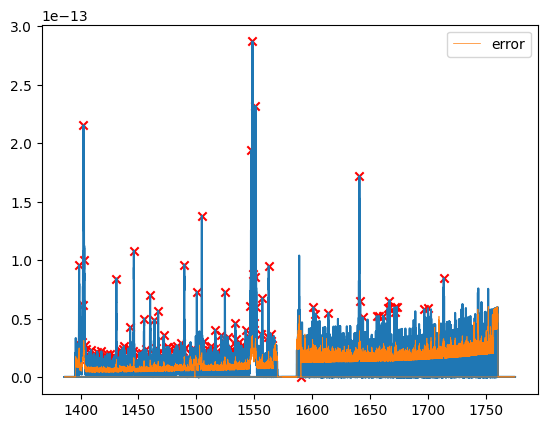

In [171]:
date_filter = all_spectra.spec_df['obsdate']=='2022-08-14'

flux = all_spectra.spec_df.loc[date_filter, 'flux'].values[0].value
fluxerr = all_spectra.spec_df.loc[date_filter, 'fluxerr'].values[0].value
wavelength = all_spectra.spec_df.loc[date_filter, 'wavelength'].values[0].value

peaks, _ = find_peaks(flux, height=fluxerr*2, distance=50)
#print(peaks)
plt.plot(wavelength, flux)
plt.scatter(wavelength[peaks], flux[peaks], c='red', marker='x')
#plt.hlines(np.mean(fluxerr[flux>0]), min(wavelength), max(wavelength), 'r','--')
plt.plot(wavelength, fluxerr, lw=0.5, label='error')
plt.legend()
#plt.xlim(left=1390)
plt.show()

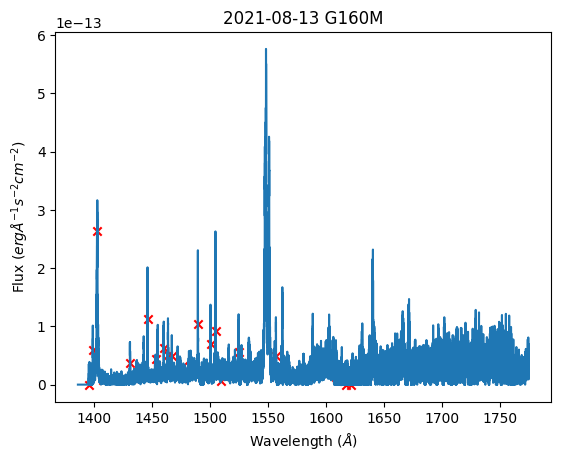

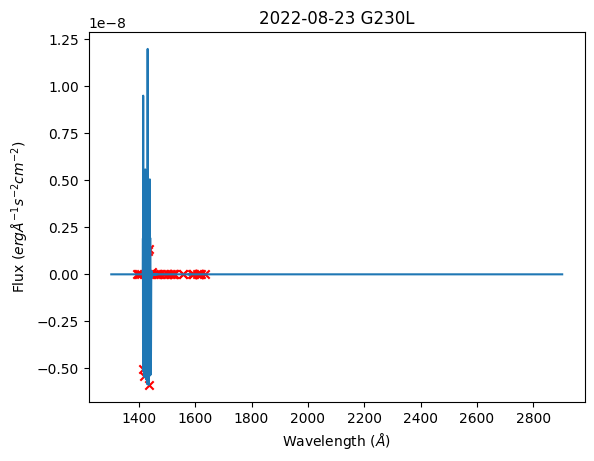

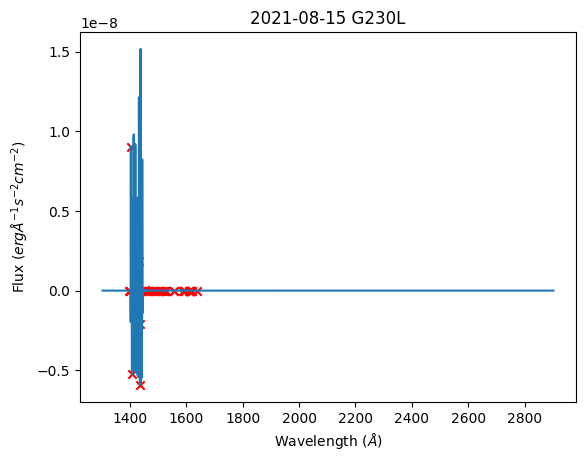

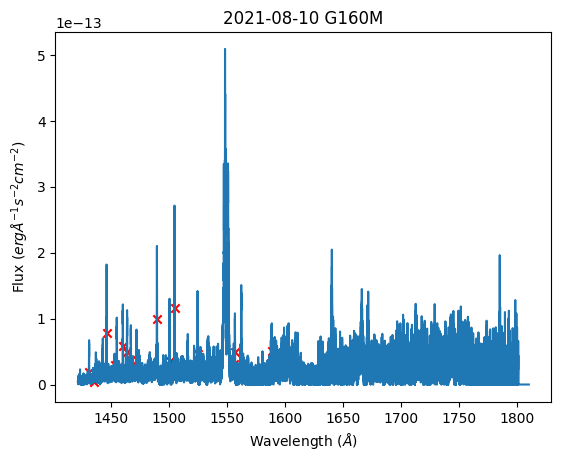

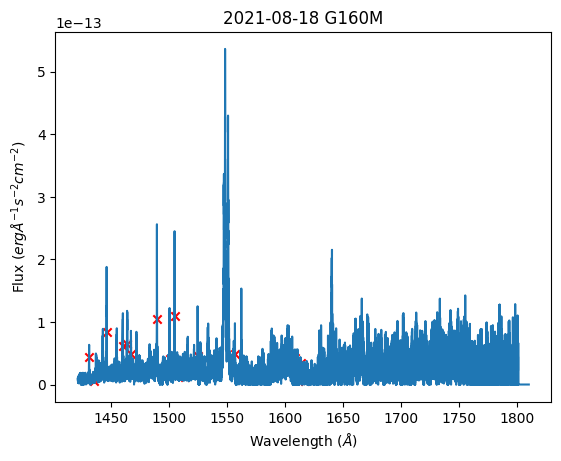

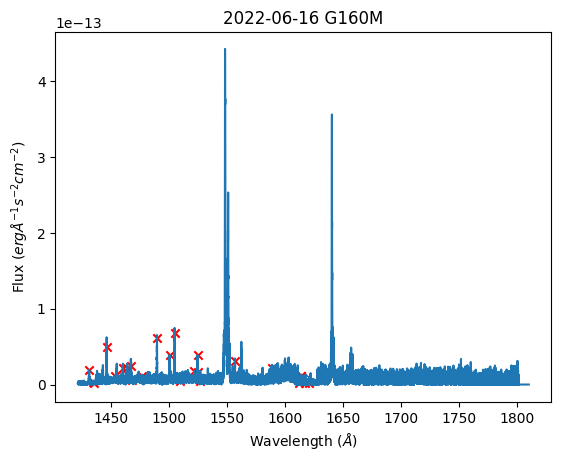

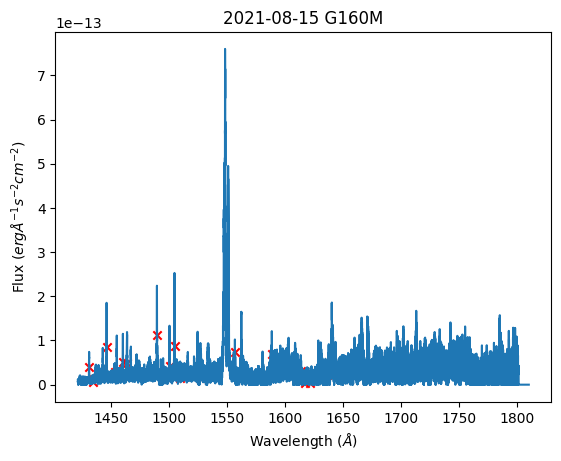

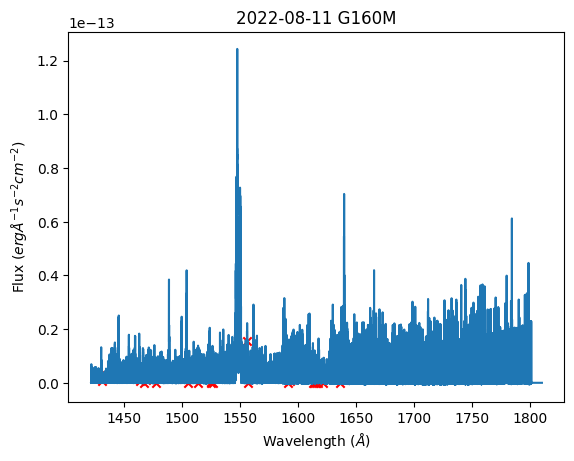

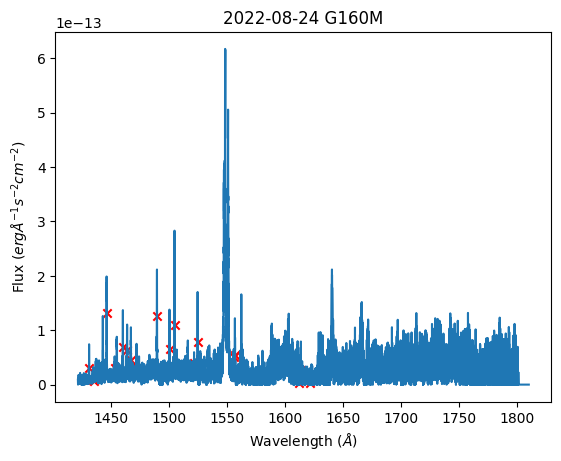

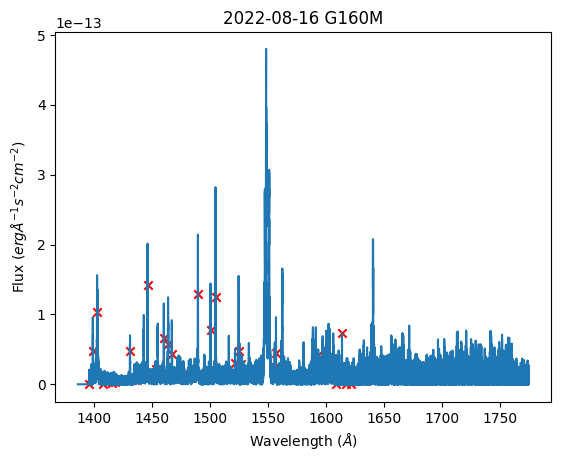

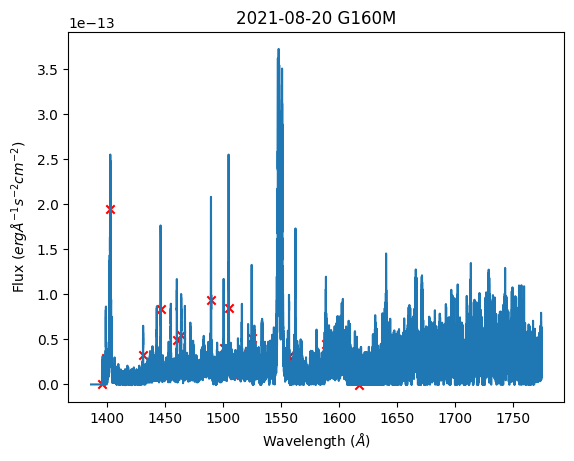

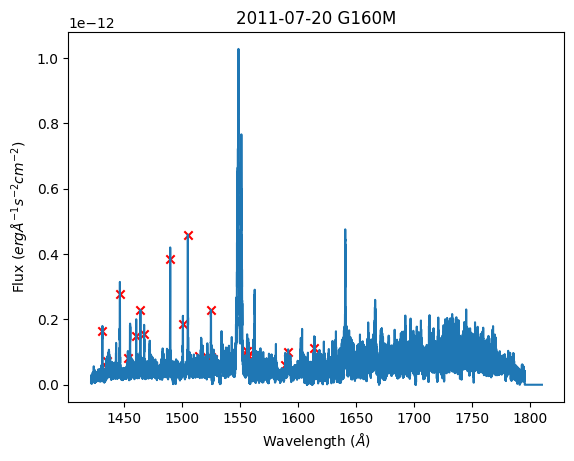

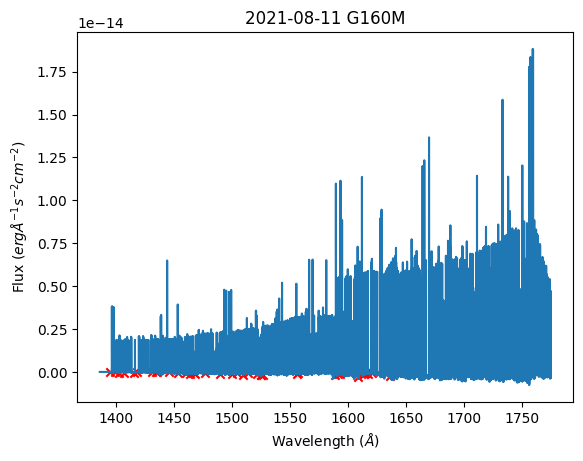

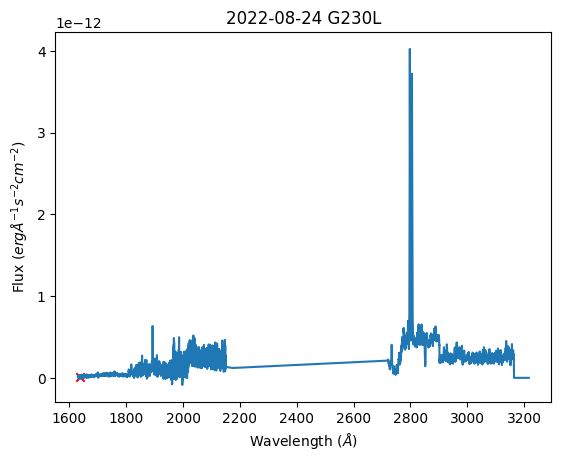

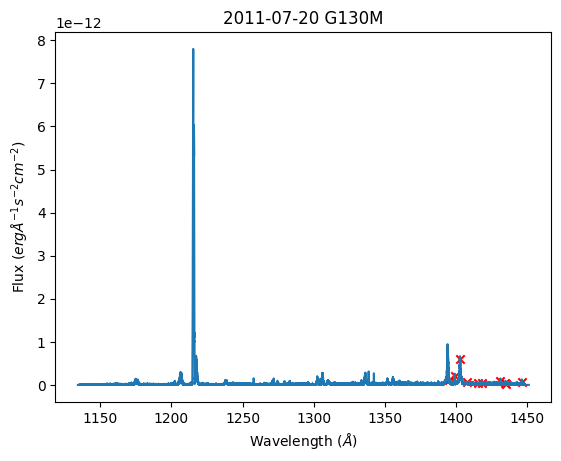

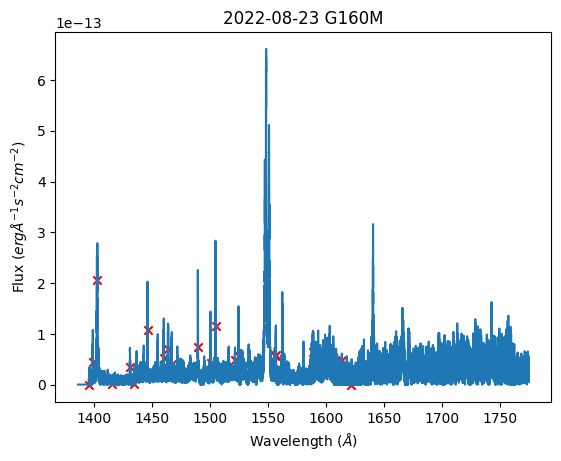

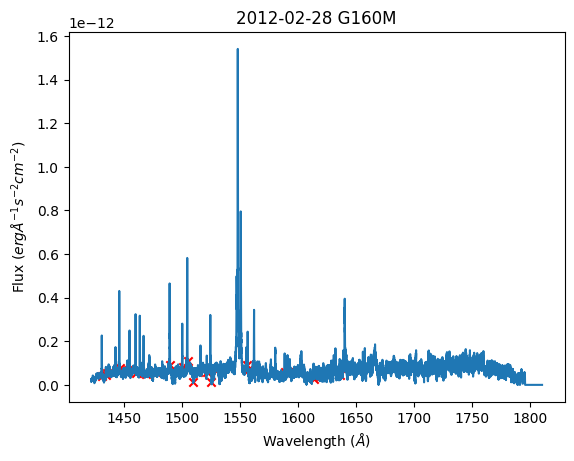

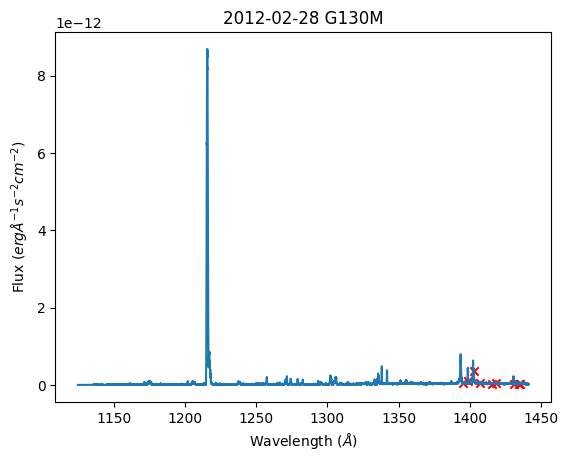

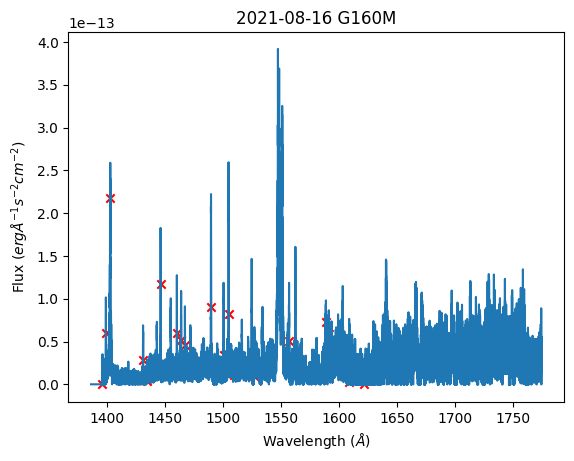

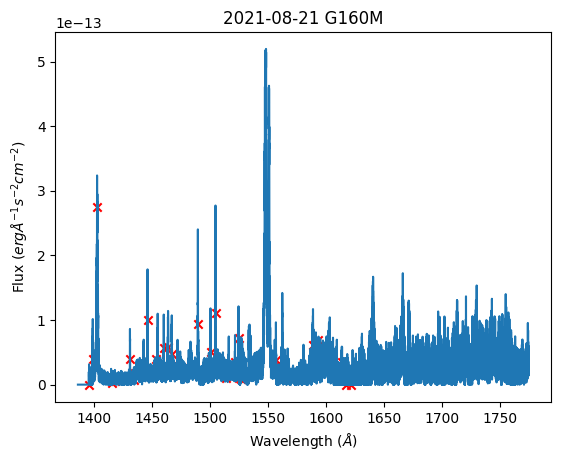

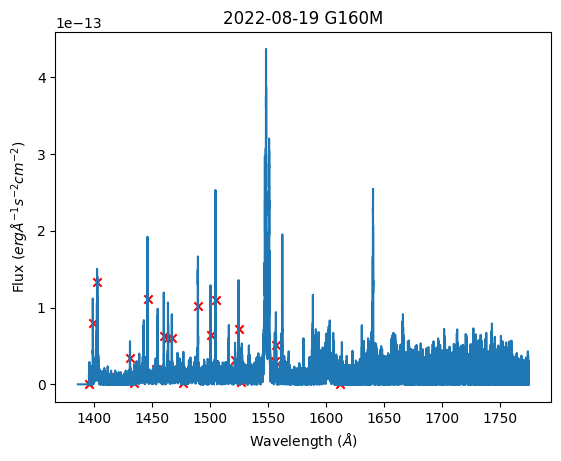

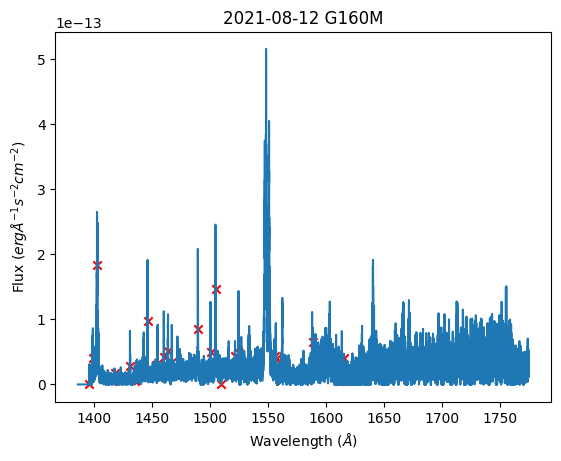

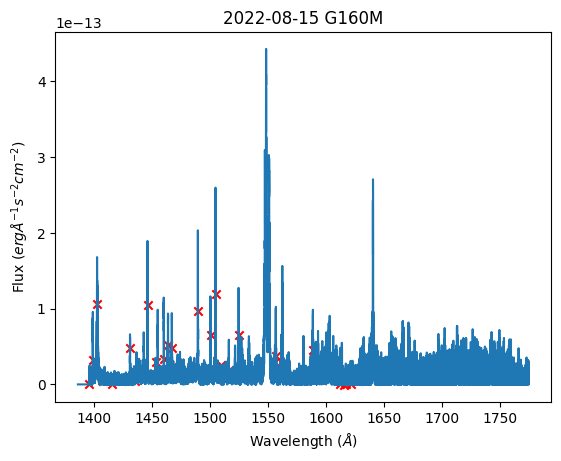

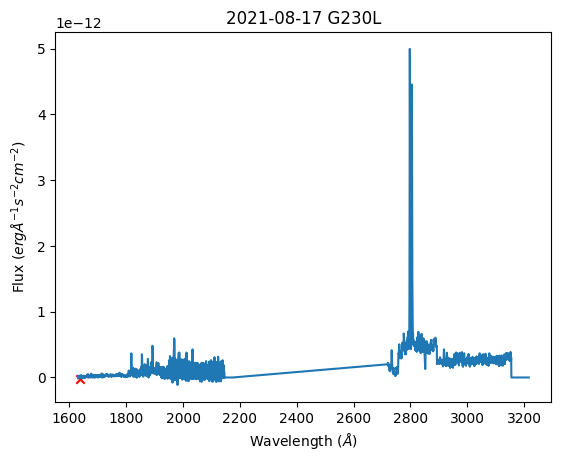

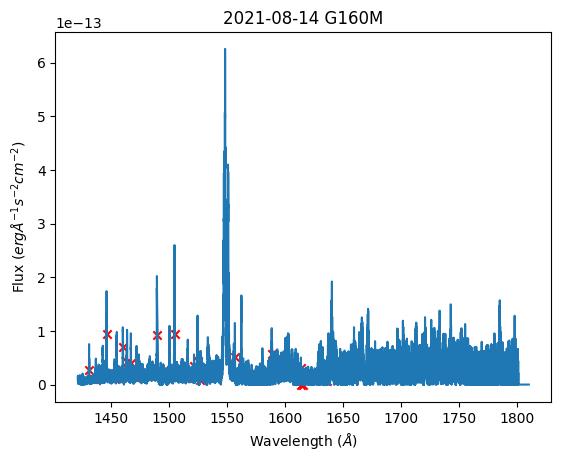

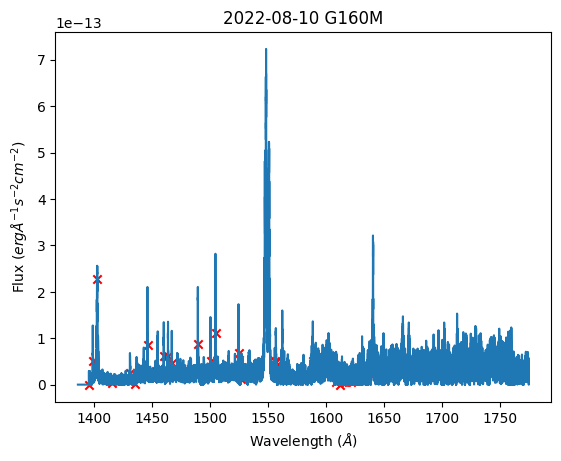

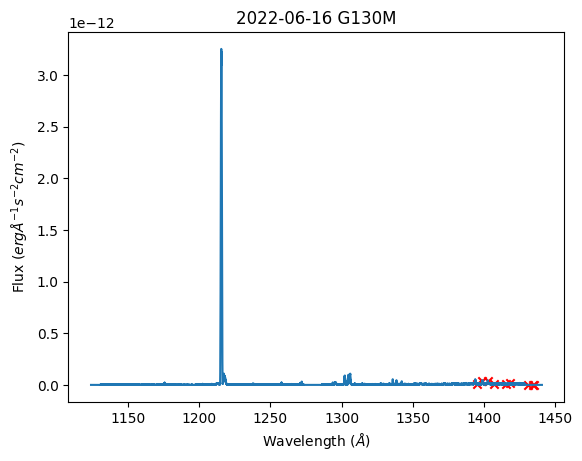

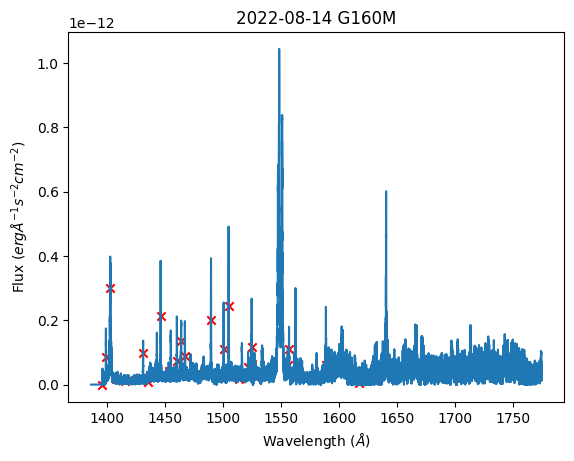

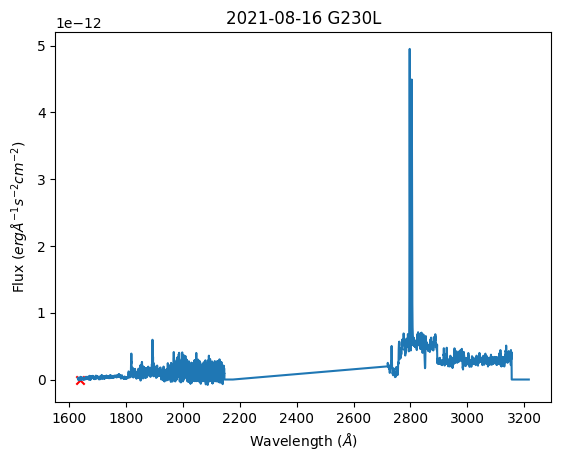

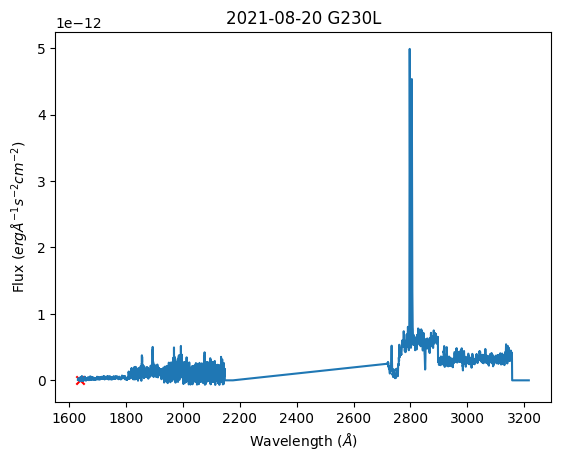

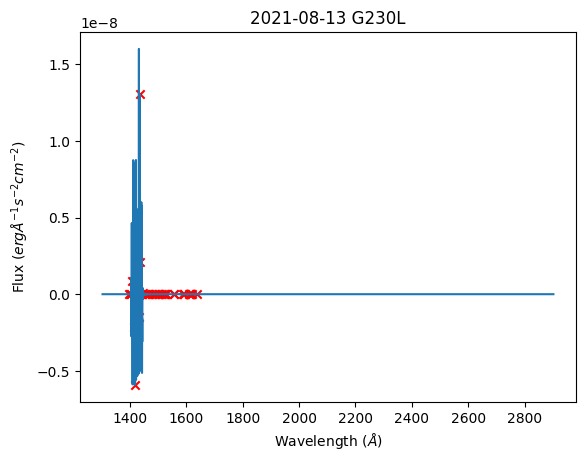

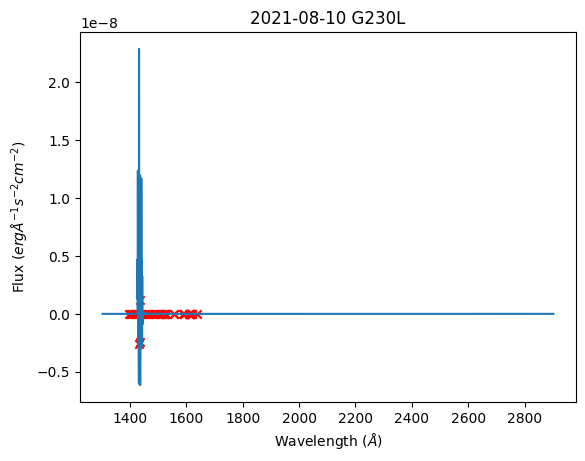

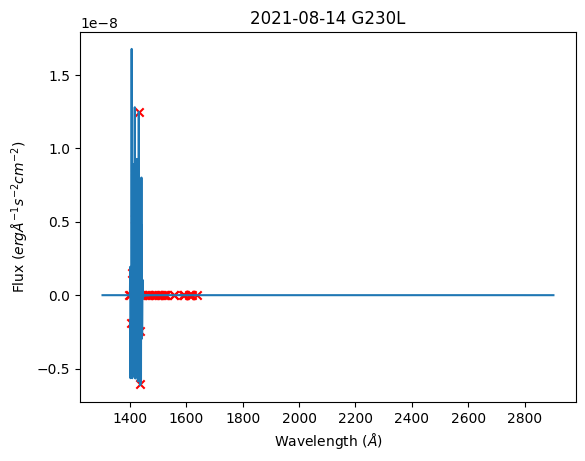

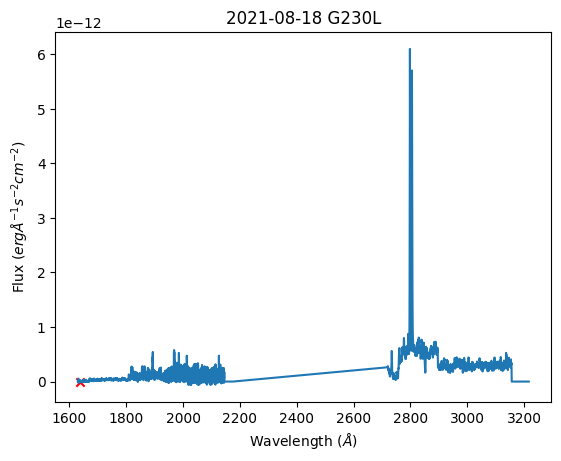

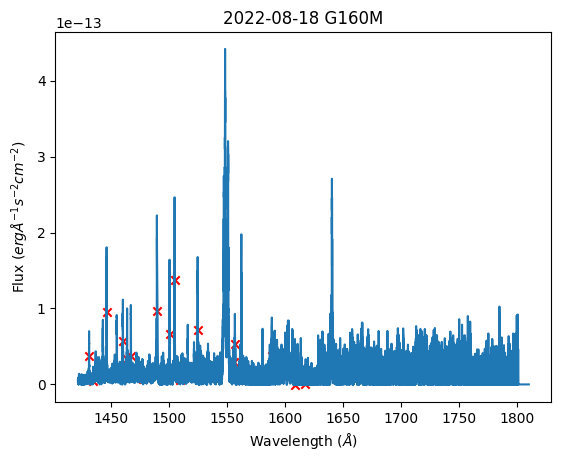

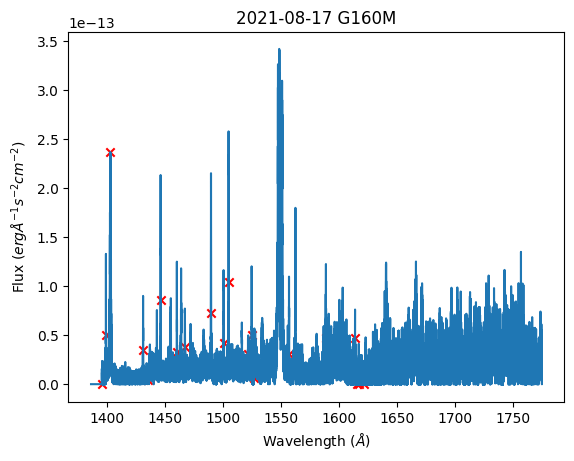

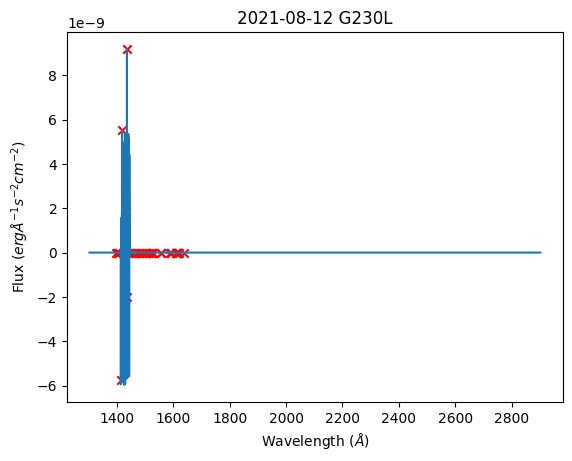

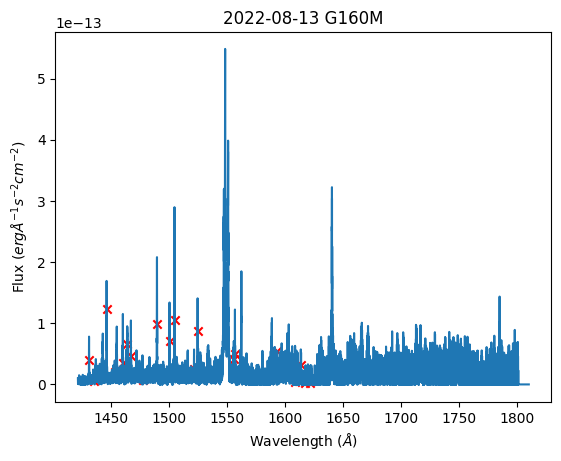

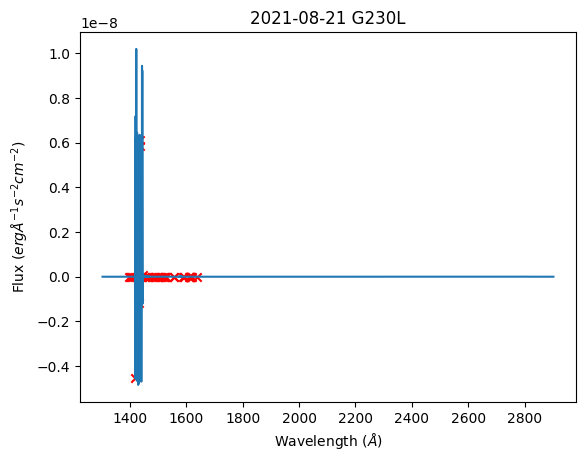

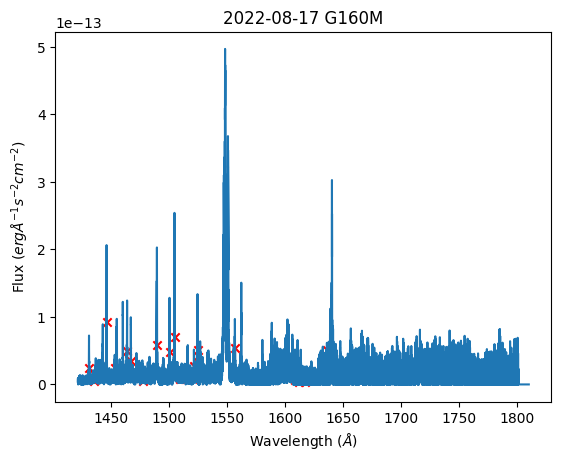

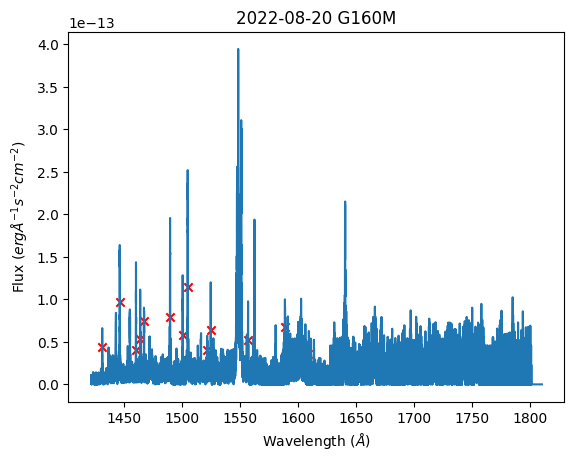

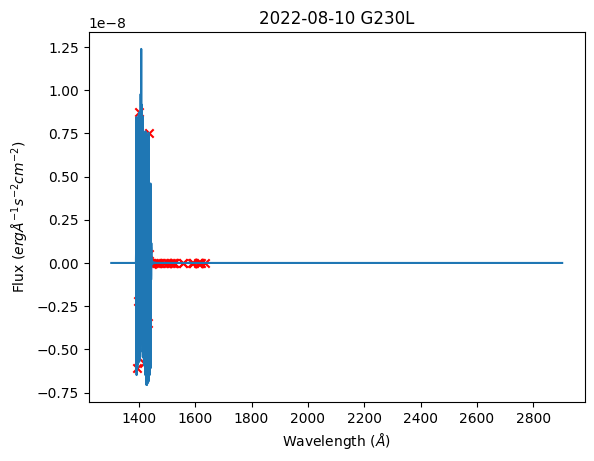

In [172]:
for _, row in stacked_df.iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.scatter(row['wavelength'][row['H2line_idx']], row['flux'][row['H2line_idx']], c='r', marker='x')
    plt.title(row['obsdate']+' '+row['filter'])
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()

# Now investigate individual lines

In [27]:
stacked_df = stacked_df[stacked_df['filter']!='G230L']
stacked_df = stacked_df[stacked_df["[nu', J']"].notna()] #remove the spectra (coadded for one observation date) that don't have any H2 lines
stacked_df

obsdate filter                                         wavelength  \
0   2021-08-13  G160M  [1385.9931276253203 Angstrom, 1386.00536736705...   
3   2021-08-10  G160M  [1421.254196584923 Angstrom, 1421.266445181324...   
4   2021-08-18  G160M  [1421.250438441241 Angstrom, 1421.262687005296...   
5   2022-06-16  G160M  [1421.3367712210866 Angstrom, 1421.34902052907...   
6   2021-08-15  G160M  [1421.251682067404 Angstrom, 1421.263930642086...   
7   2022-08-11  G160M  [1421.254063552068 Angstrom, 1421.266312147713...   
8   2022-08-24  G160M  [1421.2488942629827 Angstrom, 1421.26114281391...   
9   2022-08-16  G160M  [1385.9917161124404 Angstrom, 1386.00395584173...   
10  2021-08-20  G160M  [1385.9903407572133 Angstrom, 1386.00258047415...   
11  2011-07-20  G160M  [1421.2426308057047 Angstrom, 1421.25487447368...   
12  2021-08-11  G160M  [1385.9941396590698 Angstrom, 1386.00637941009...   
14  2011-07-20  G130M  [1134.4087919542987 Angstrom, 1134.41875630458...   
15  2022-08-23  G160M  [1385.9896587703408 Angstrom, 1386.00189848125...   
16  2012-02-28  G160M  [1421.484376179013 Angstrom, 1421.496621929407...   
17  2012-02-28  G130M  [1124.9096635174221 Angstrom, 1124.91962690073...   
18  2021-08-16  G160M  [1385.9916804390439 Angstrom, 1386.00392016811...   
19  2021-08-21  G160M  [1385.9900462627913 Angstrom, 1386.00228597737...   
20  2022-08-19  G160M  [1385.9906740586073 Angstrom, 1386.00291377859...   
21  2021-08-12  G160M  [1385.9934968299058 Angstrom, 1386.00573657483...   
22  2022-08-15  G160M  [1385.9921428581877 Angstrom, 1386.00438259114...   
24  2021-08-14  G160M  [1421.2521631419022 Angstrom, 1421.26441172082...   
25  2022-08-10  G160M  [1385.9951835939507 Angstrom, 1386.00742335376...   
26  2022-06-16  G130M  [1124.1220811272192 Angstrom, 1124.13204848542...   
27  2022-08-14  G160M  [1385.9929259052471 Angstrom, 1386.00516564510...   
34  2022-08-18  G160M  [1421.2504525805757 Angstrom, 1421.26270114460...   
35  2021-08-17  G160M  [1385.9912497641506 Angstrom, 1386.00348948963...   
37  2022-08-13  G160M  [1421.2530339201037 Angstrom, 1421.26528250643...   
39  2022-08-17  G160M  [1421.250823324304 Angstrom, 1421.263071891649...   
40  2022-08-20  G160M  [1421.249797536383 Angstrom, 1421.262046095076...   

                                                 flux  \
0   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
3   [4.736898099985594e-15 erg / (Angstrom s cm2),...   
4   [8.536568923043122e-15 erg / (Angstrom s cm2),...   
5   [8.842805948548497e-16 erg / (Angstrom s cm2),...   
6   [5.668530234803062e-15 erg / (Angstrom s cm2),...   
7   [-2.957552869772527e-17 erg / (Angstrom s cm2)...   
8   [9.00888619710672e-15 erg / (Angstrom s cm2), ...   
9   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
10  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
11  [7.428045243004162e-15 erg / (Angstrom s cm2),...   
12  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
14  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
15  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
16  [1.9402935879202436e-14 erg / (Angstrom s cm2)...   
17  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
18  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
19  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
20  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
21  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
22  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
24  [8.965422452464702e-15 erg / (Angstrom s cm2),...   
25  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
26  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
27  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
34  [5.921033197360536e-15 erg / (Angstrom s cm2),...   
35  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
37  [9.827029141049102e-15 erg / (Angstrom s cm2),...   
39  [4.421725329470133e-15 erg / (Angstrom s cm2),...   
40  [1.0880142169956368e-14 erg / (Angstrom s cm2)...   

               

In [28]:
line_df = all_spectra.get_lines(stacked_df) #rearrange df by progressions, not obsdate
line_df

transition  labline     obsdate  \
0       [3,16]  1418.23  2021-08-13   
1       [3,16]  1513.99  2021-08-13   
2       [3,16]  1593.26  2021-08-13   
3       [3,16]  1621.12  2021-08-13   
4       [3,16]  1513.99  2021-08-10   
..         ...      ...         ...   
755     [2,15]  1612.39  2022-08-14   
756     [2,15]  1612.39  2022-08-18   
757     [2,15]  1612.39  2021-08-17   
758     [2,15]  1612.39  2022-08-13   
759     [2,15]  1612.39  2022-08-20   

                                            wavelength  \
0                                                   []   
1                                                   []   
2    [1386.6540736791121 Angstrom, 1386.66631342084...   
3    [1386.8376698051654 Angstrom, 1386.84990954690...   
4                                                   []   
..                                                 ...   
755  [1387.0210640533865 Angstrom, 1387.03330379324...   
756                                                 []   
757  [1386.4441196070427 Angstrom, 1386.45635933252...   
758                                                 []   
759                                                 []   

                                                  flux  \
0                                                   []   
1                                                   []   
2    [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
3    [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
4                                                   []   
..                                                 ...   
755  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
756                                                 []   
757  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
758                                                 []   
759                                                 []   

                                               fluxerr  
0                                                   []  
1                                                   []  
2    [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...  
3    [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...  
4                                                   []  
..                                                 ...  
755  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...  
756                                                 []  
757  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...  
758                                                 []  
759                                                 []  

[760 rows x 6 columns]

# Look for contaminated lines in the [0,1], [0,2], [1,4], [1,7] transitions

{'[0,3]', '[2,12]', '[0,2]', '[1,7]', '[4,13]', '[0,1]', '[3,16]', '[2,15]', '[1,4]', '[3,0]', '[4,4]', '[3,13]'}

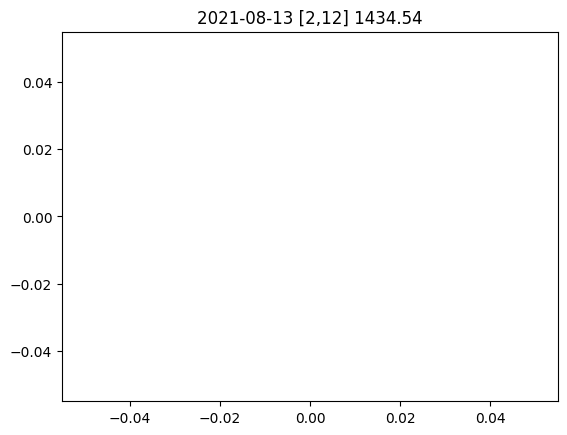

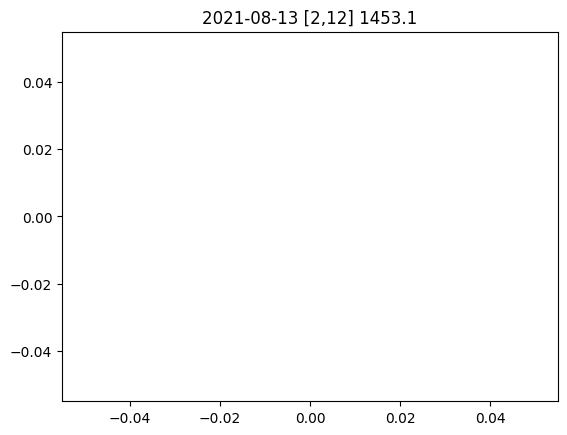

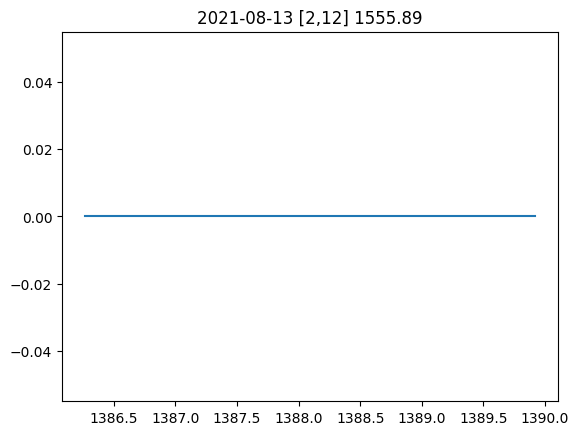

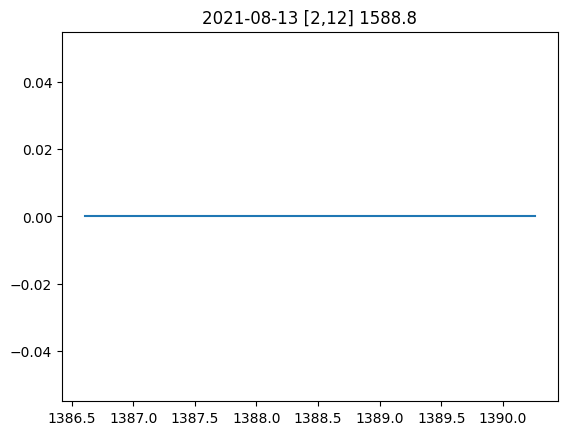

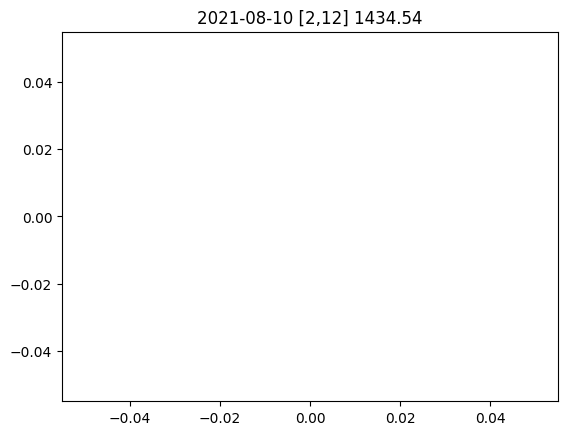

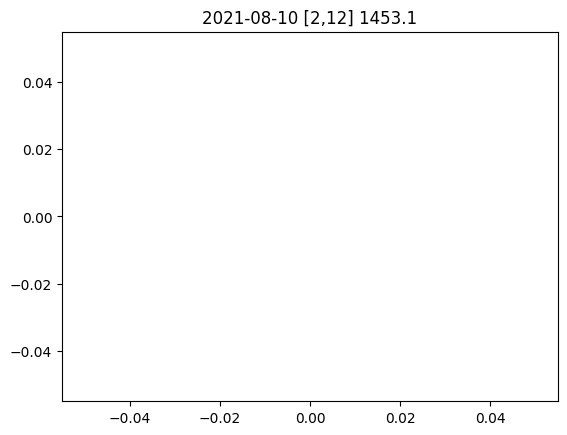

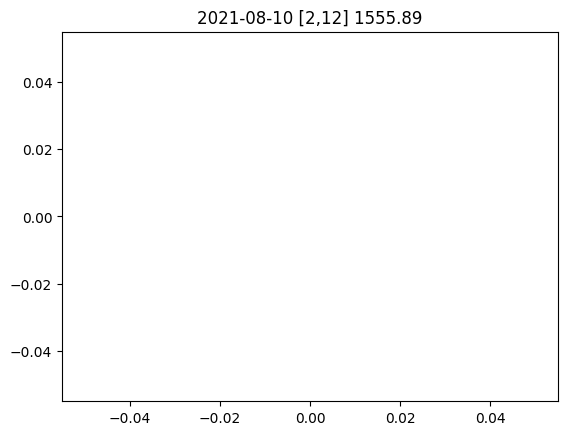

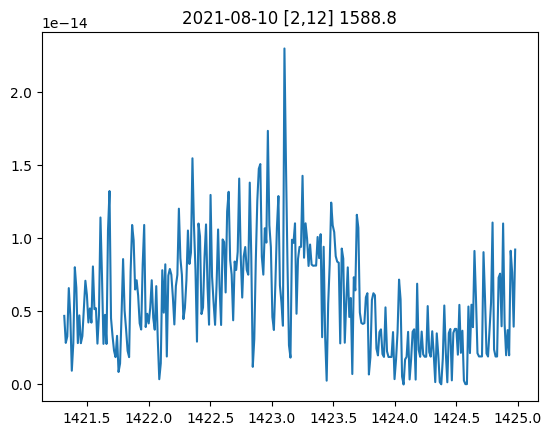

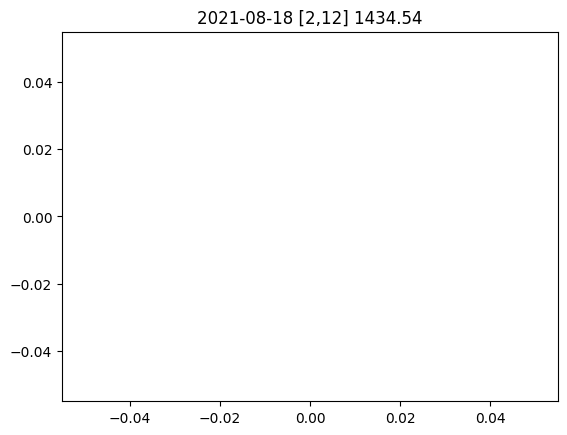

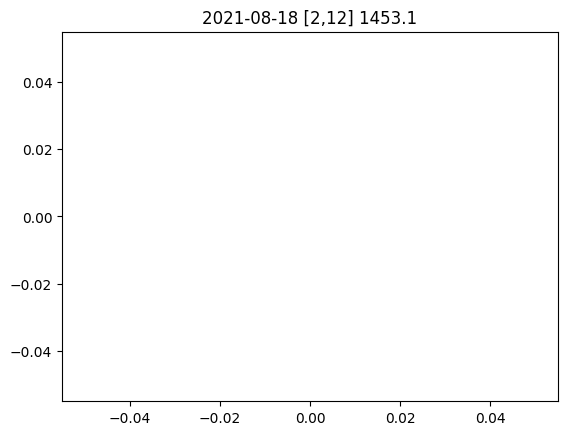

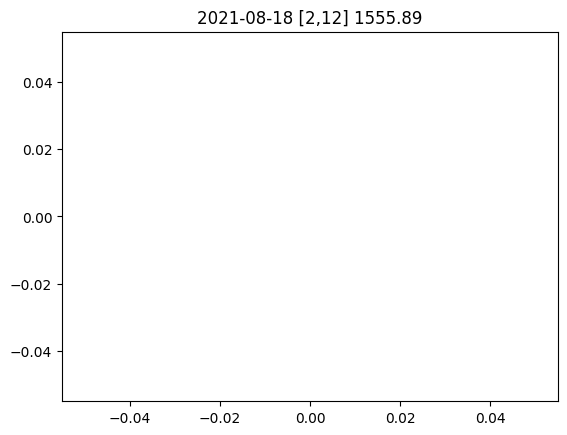

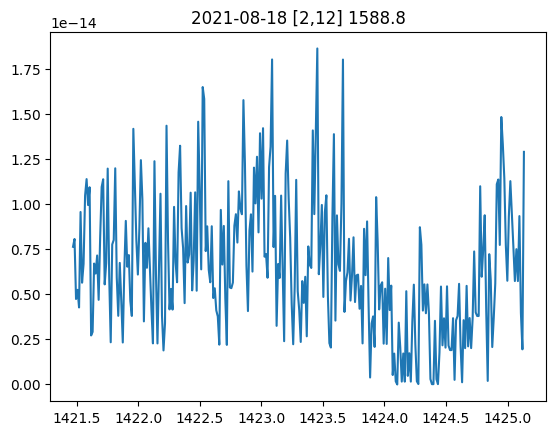

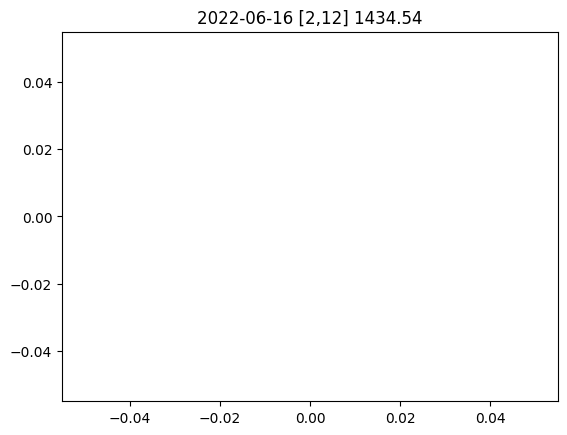

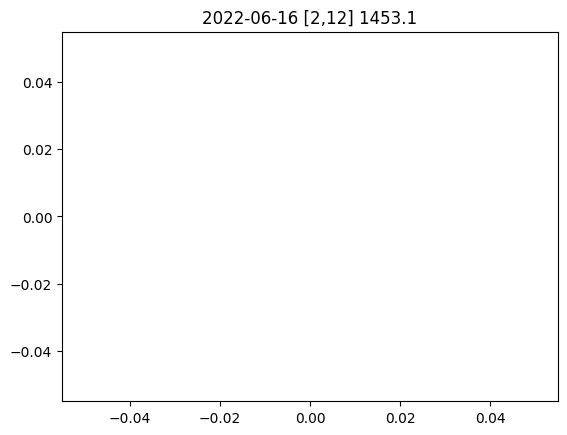

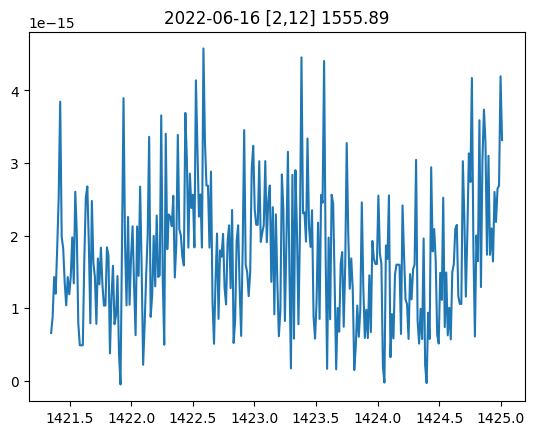

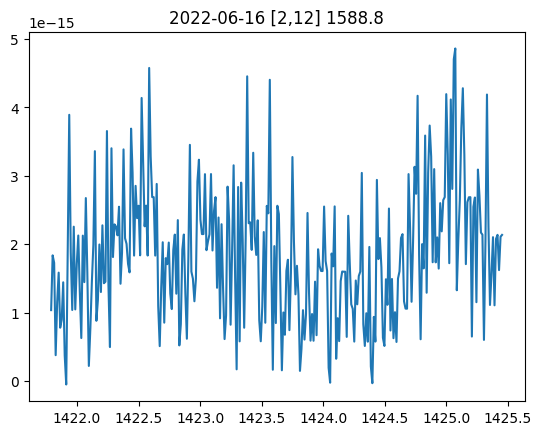

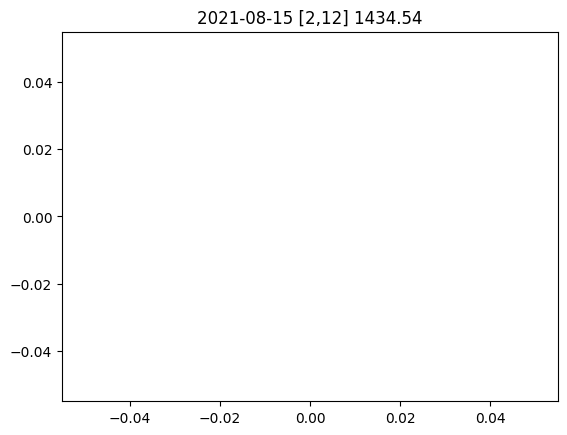

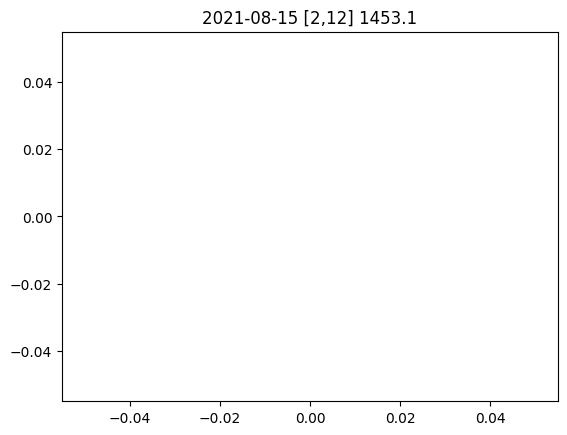

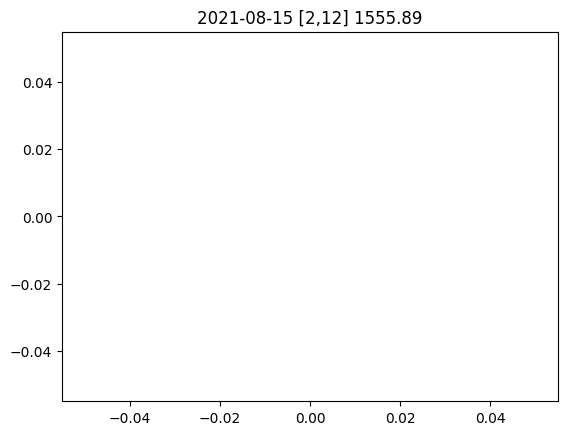

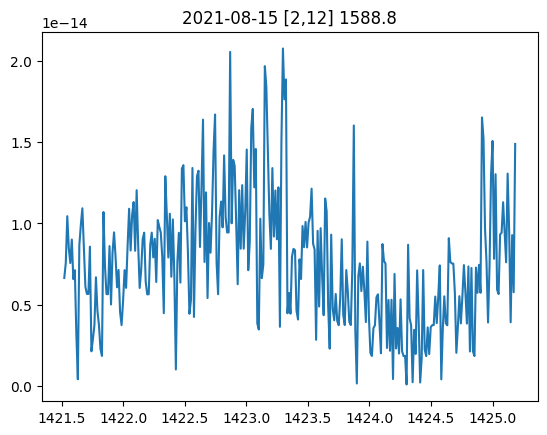

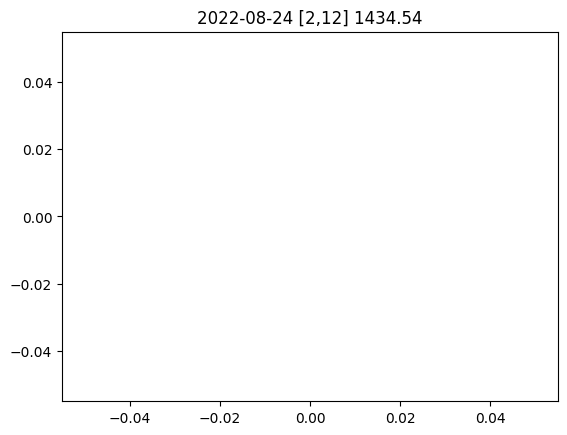

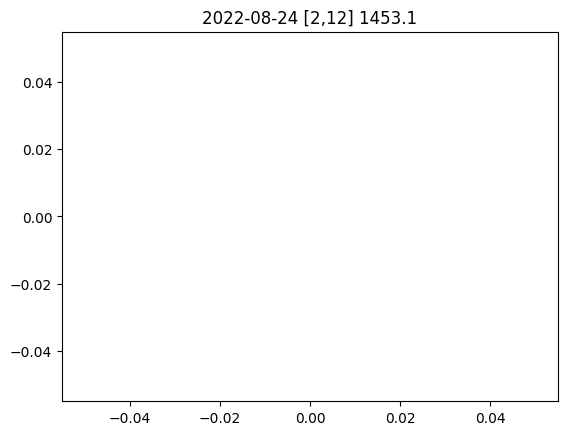

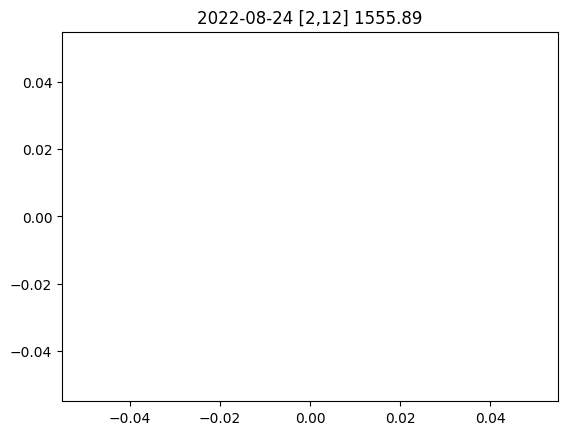

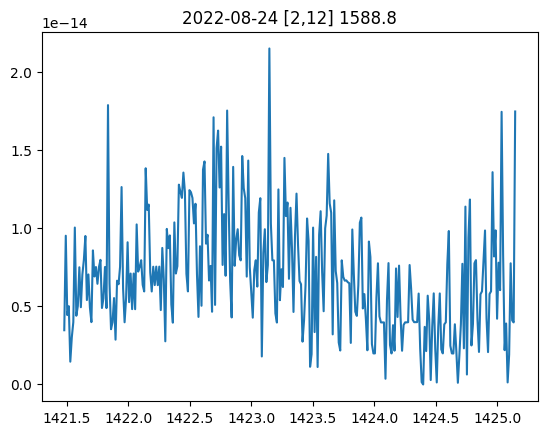

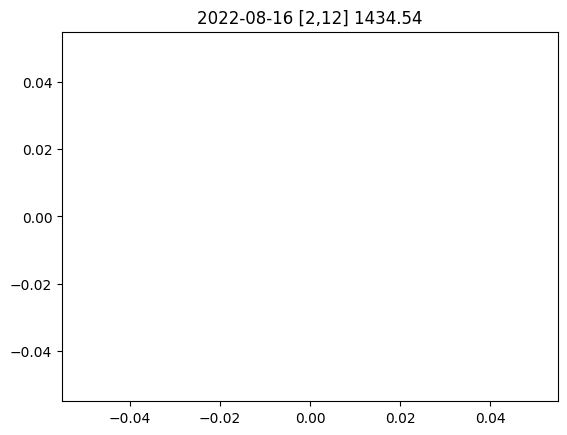

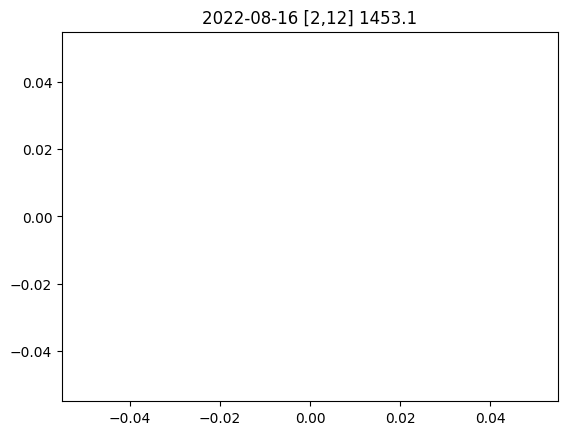

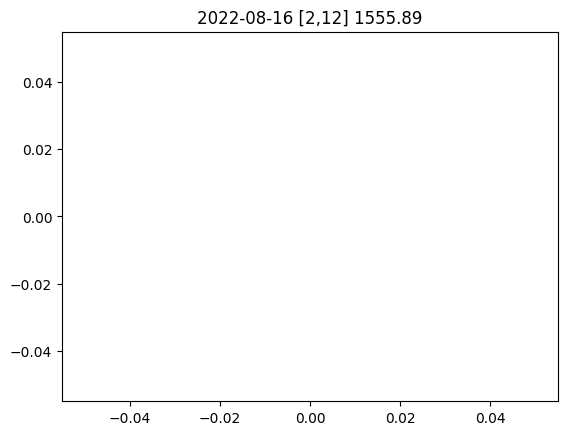

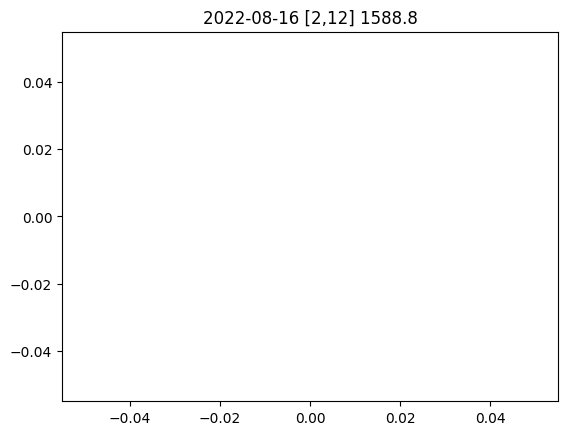

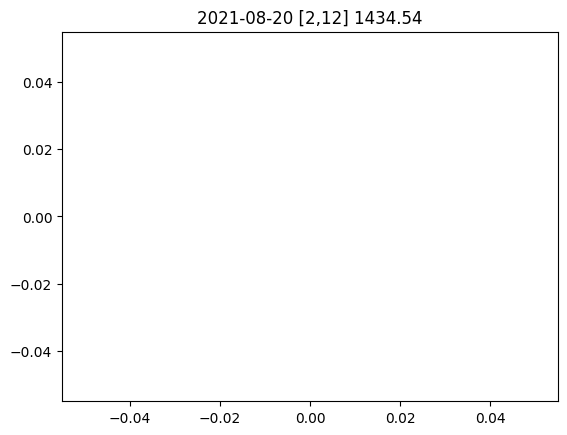

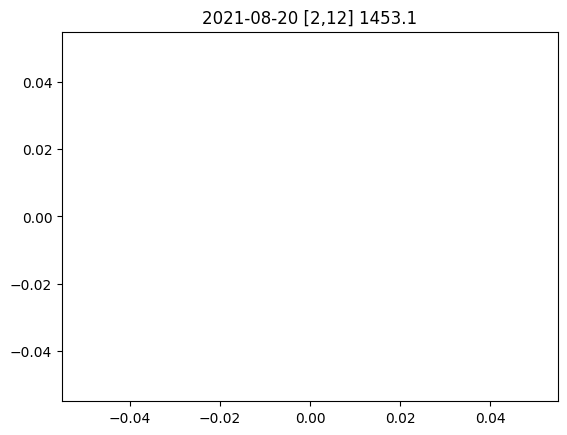

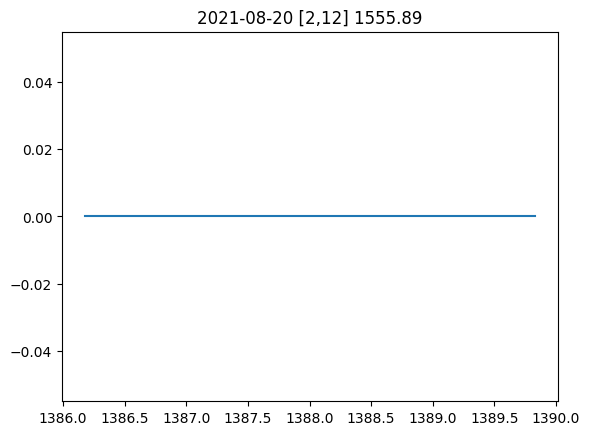

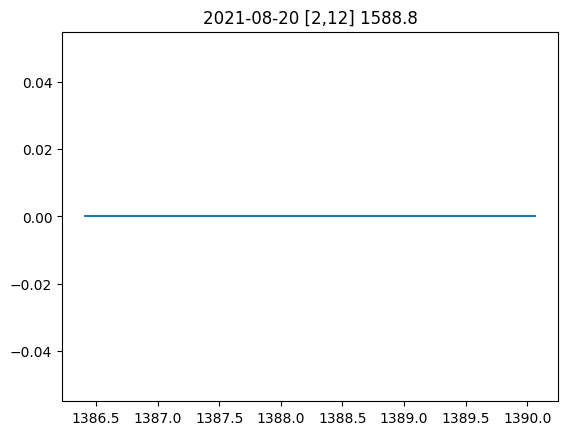

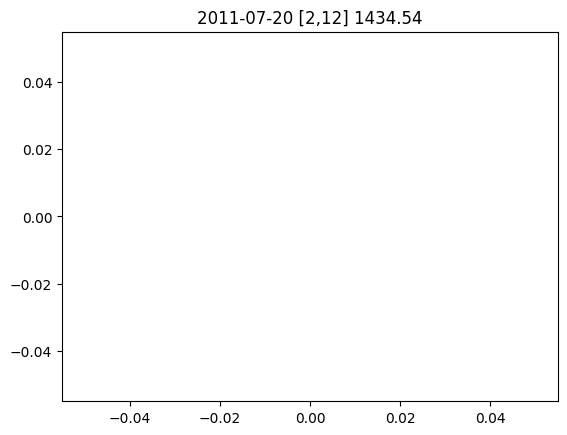

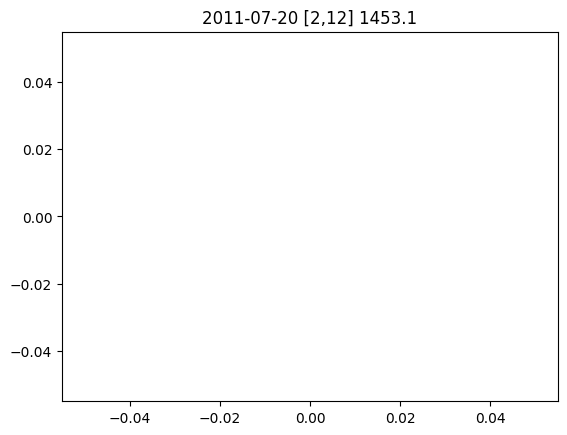

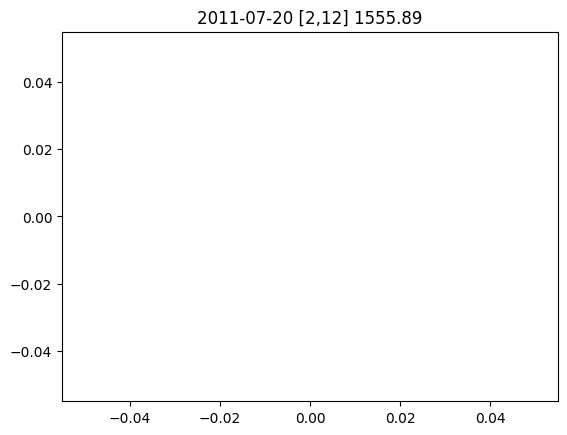

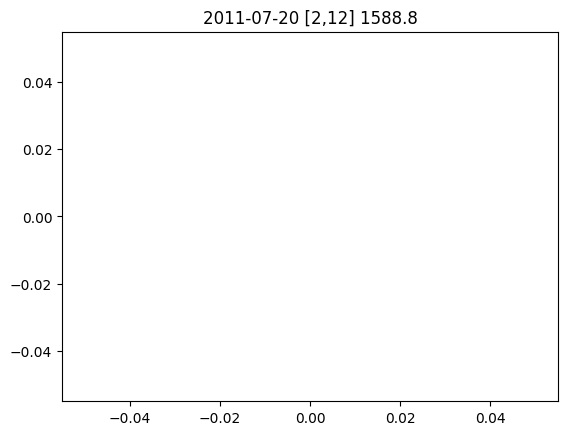

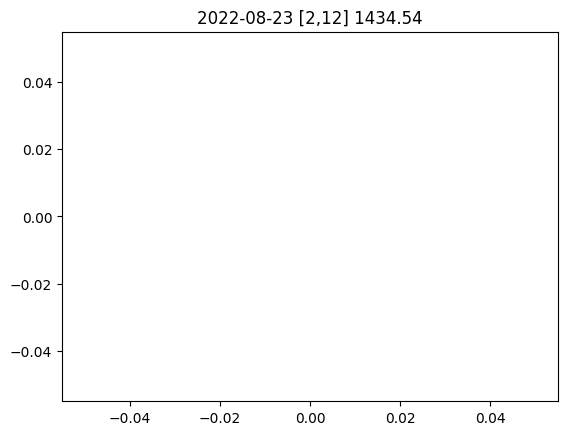

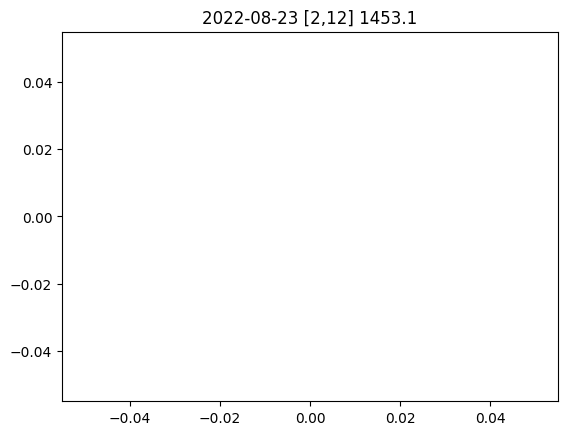

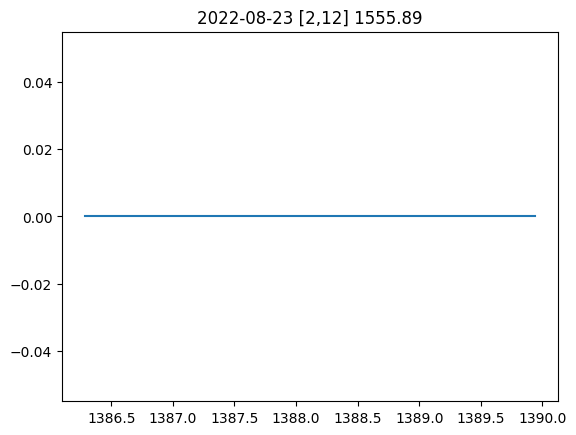

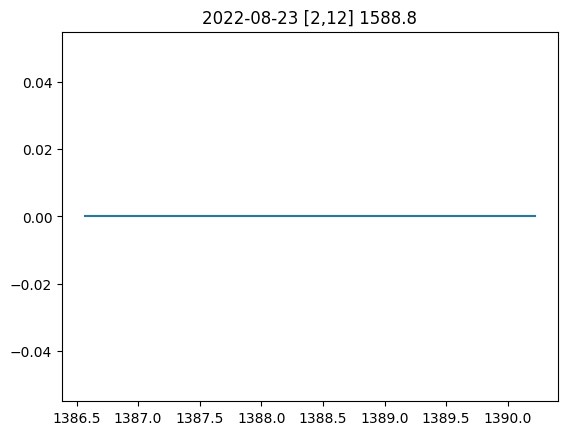

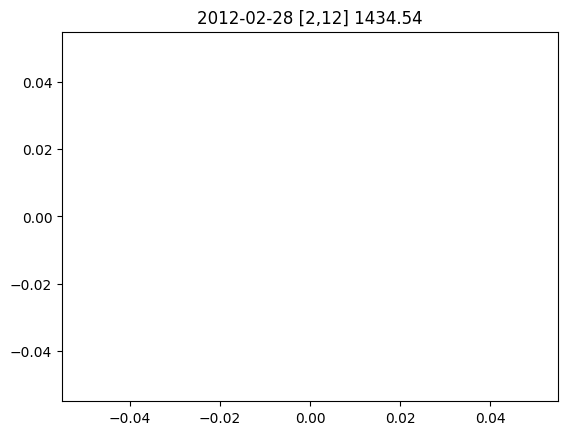

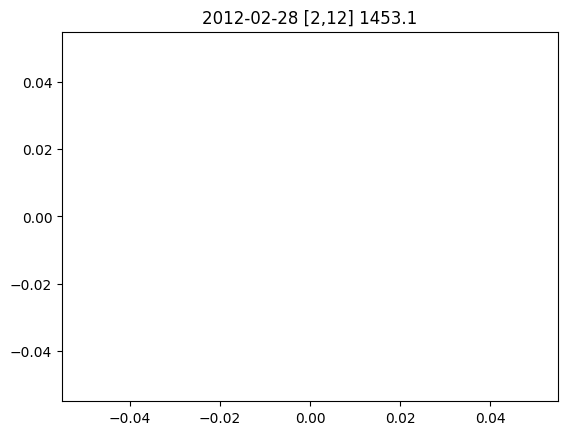

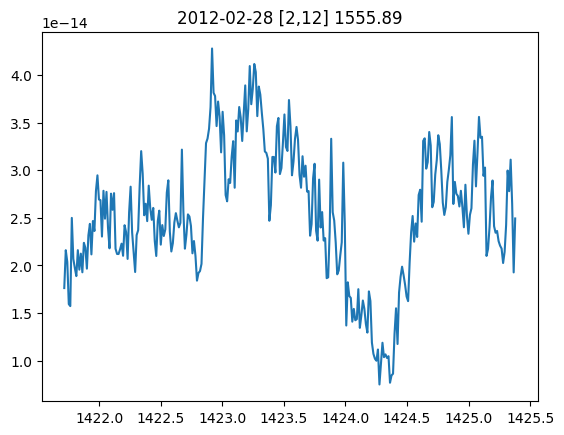

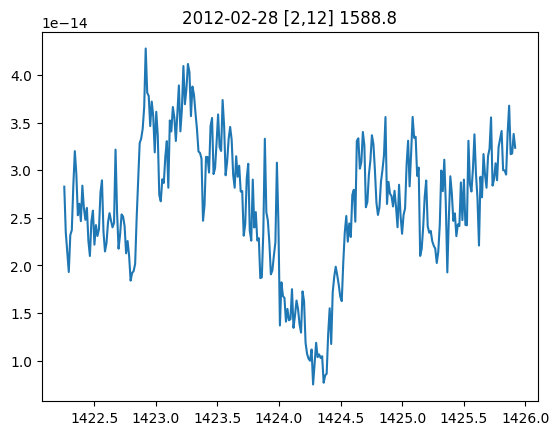

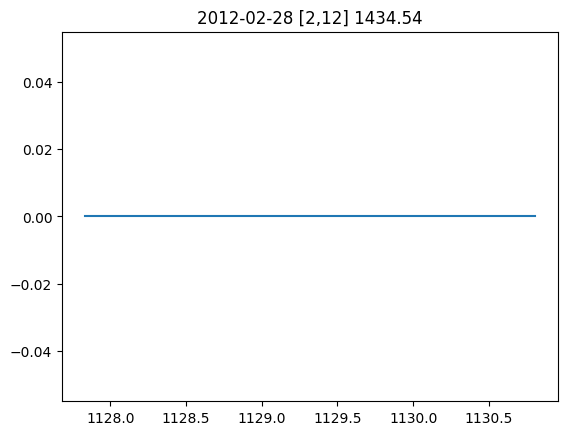

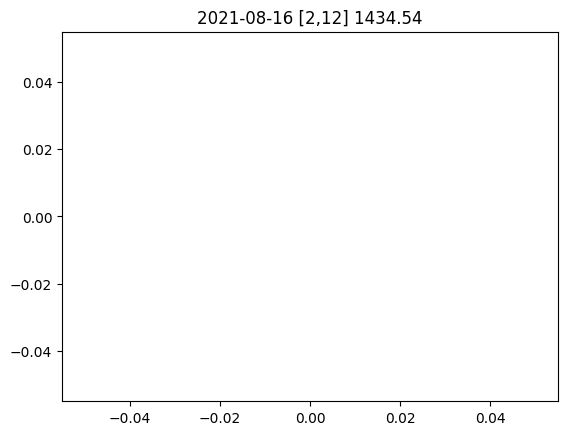

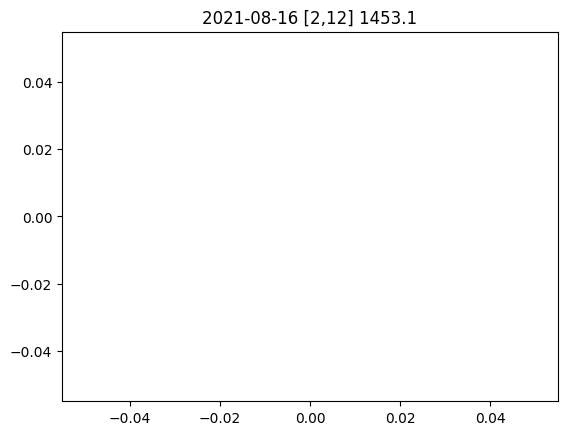

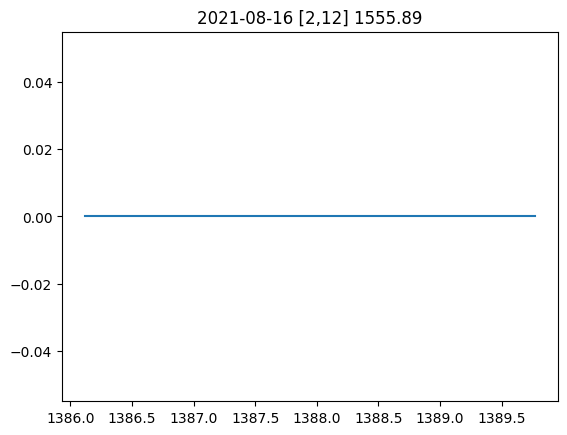

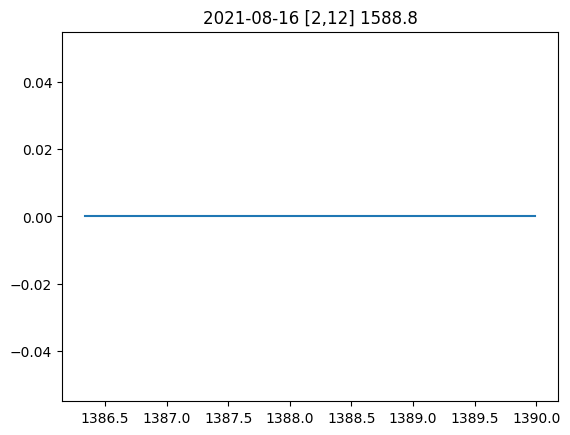

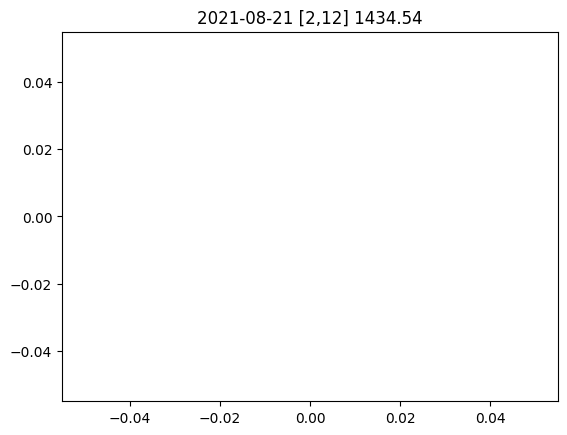

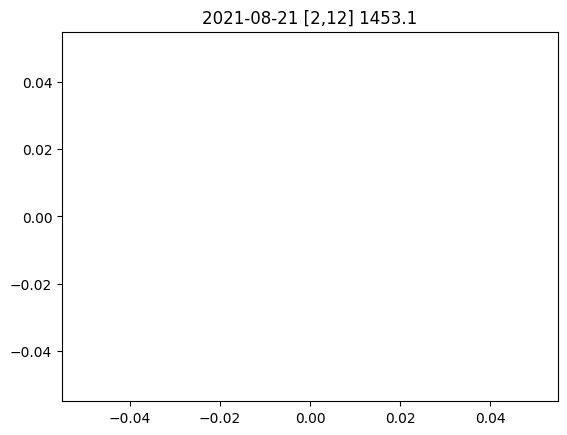

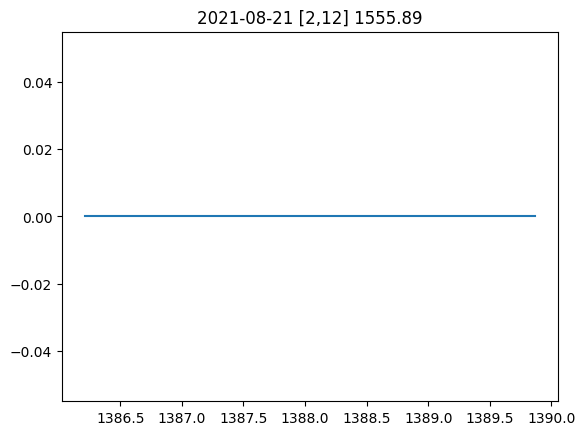

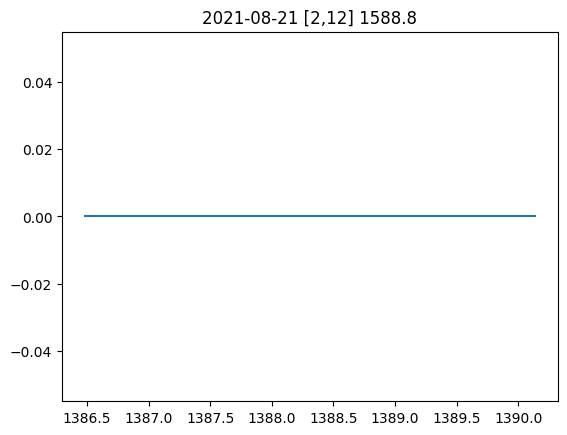

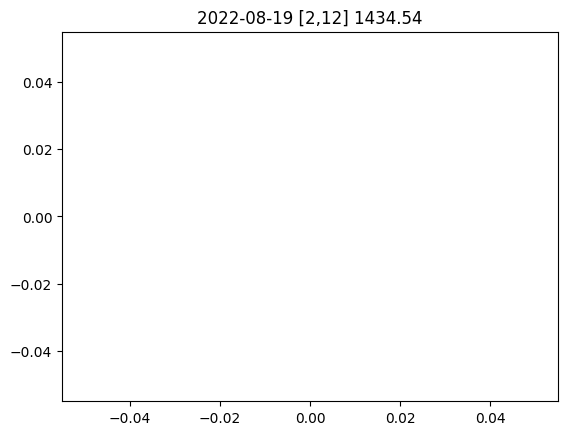

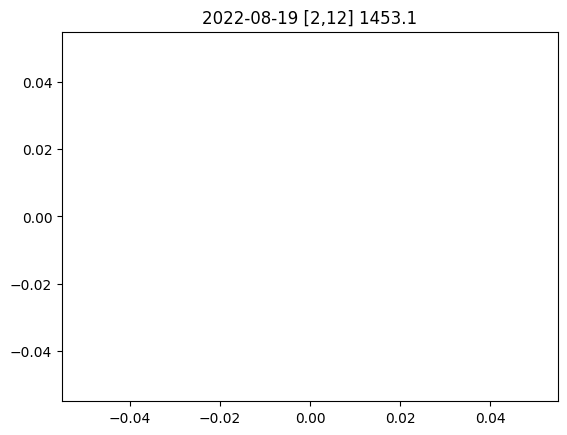

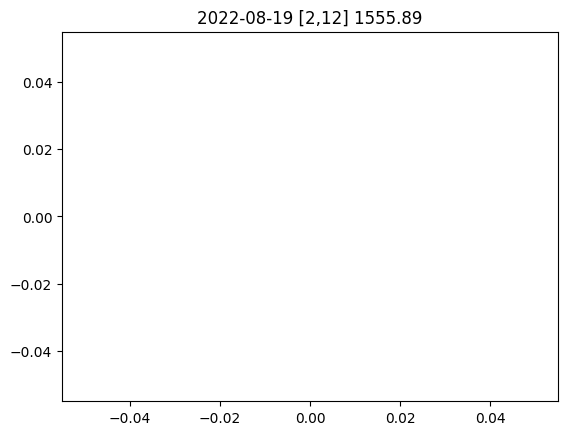

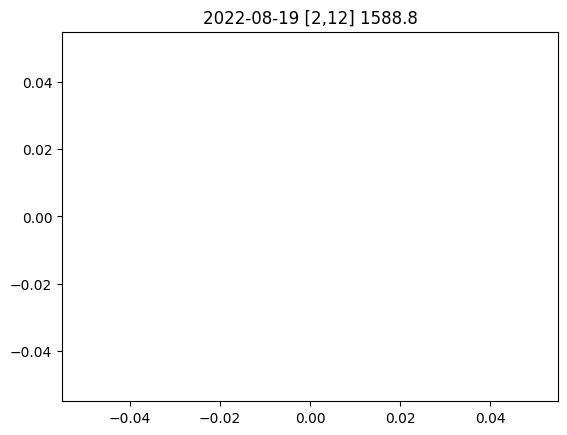

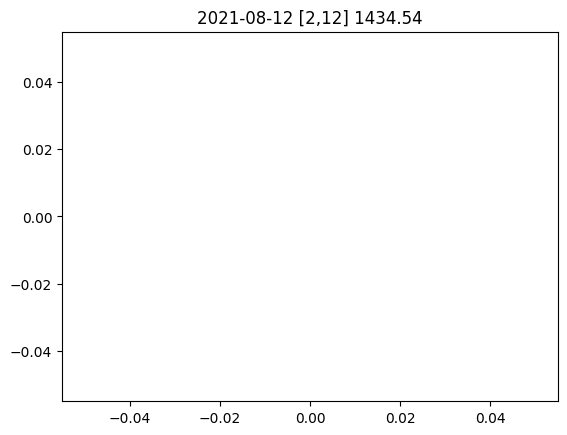

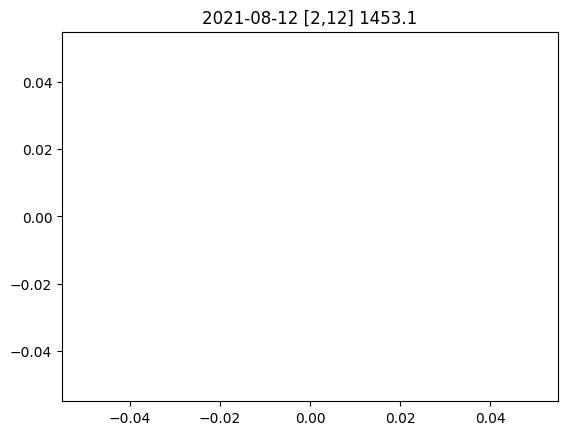

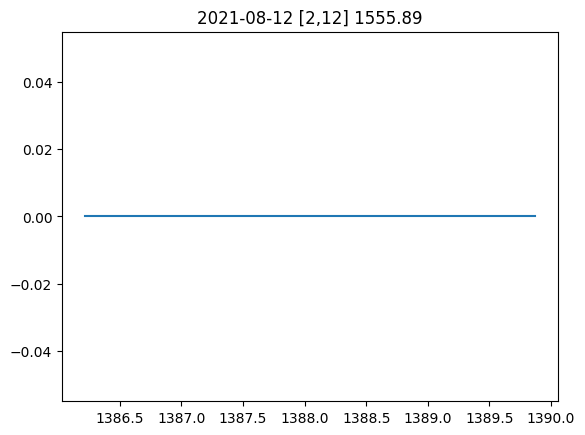

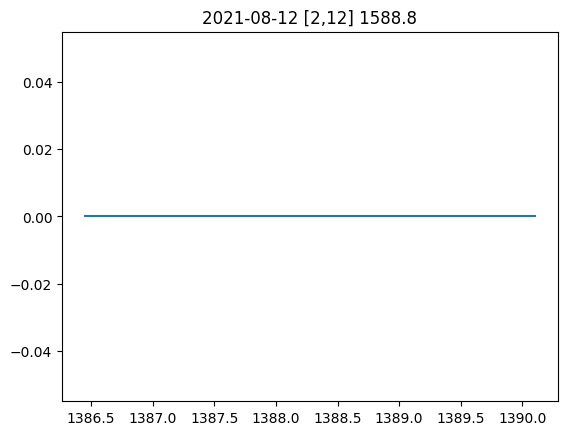

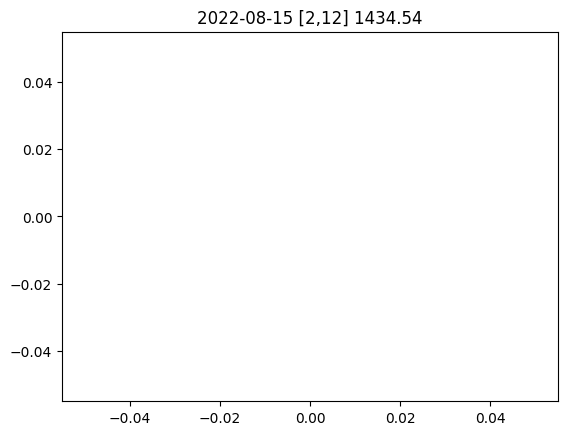

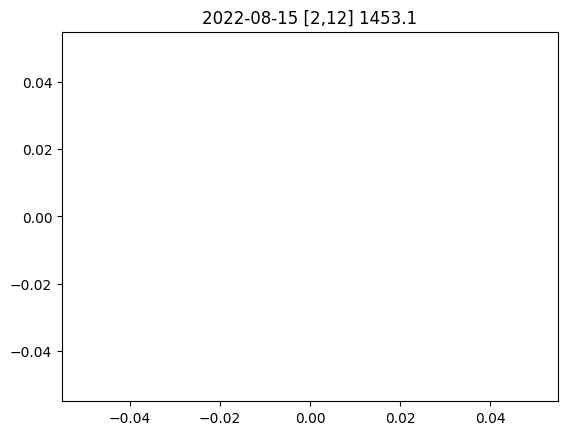

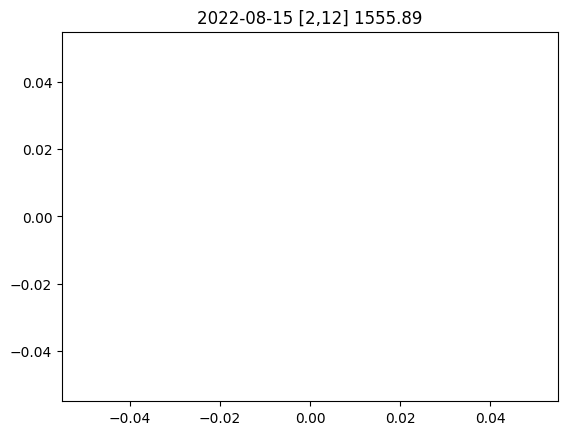

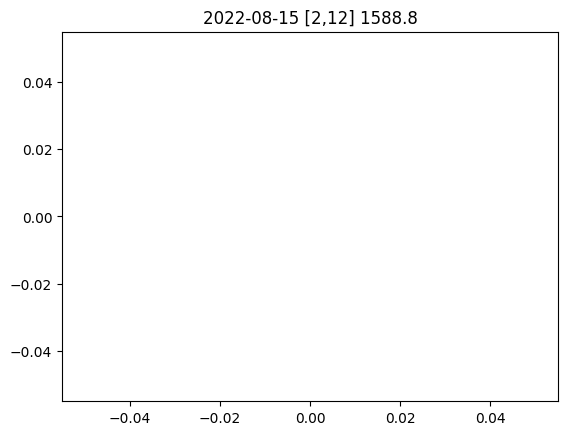

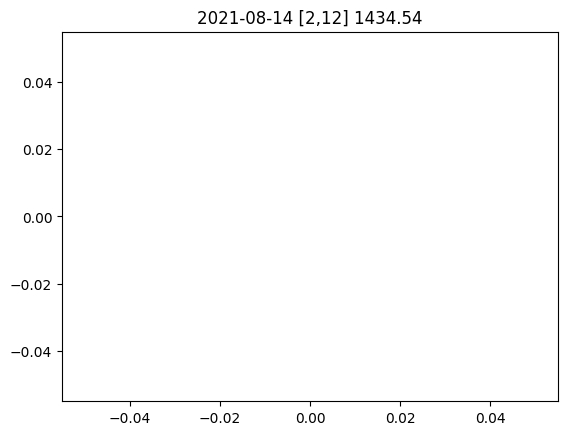

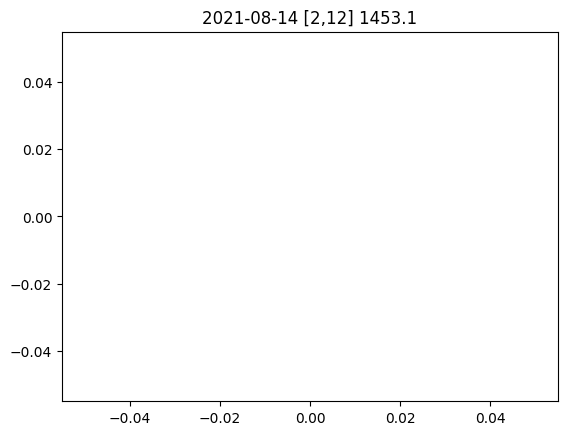

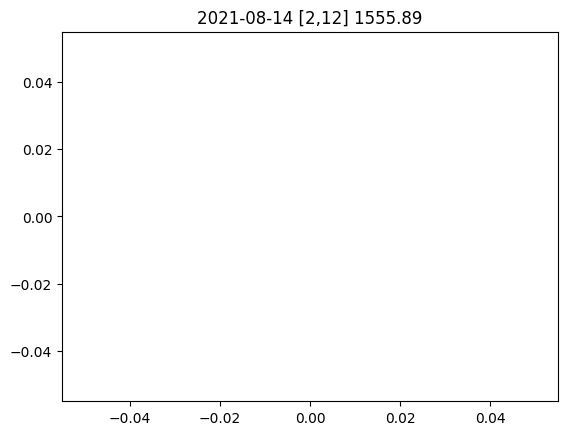

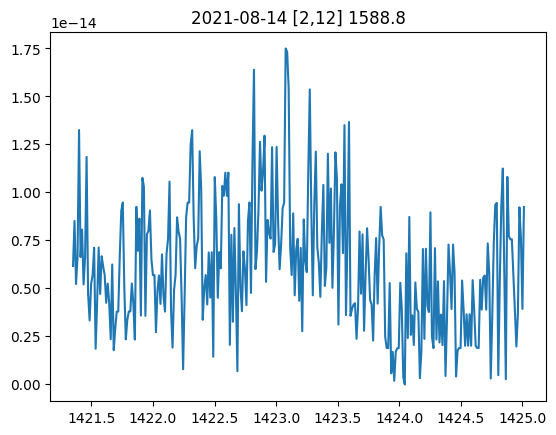

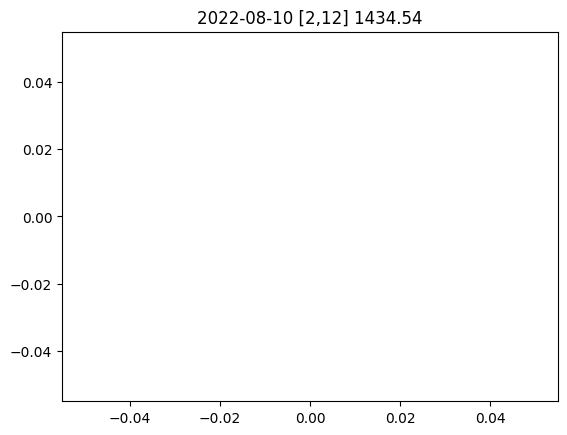

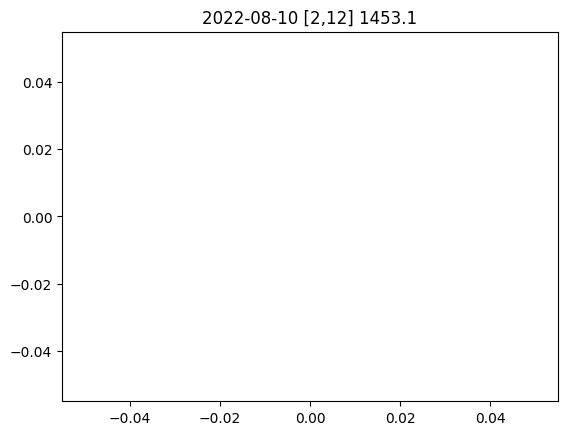

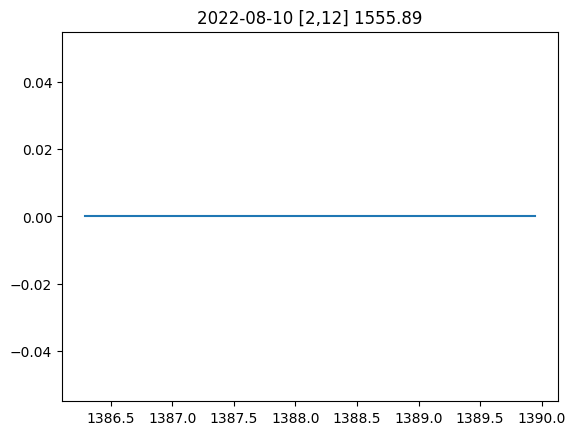

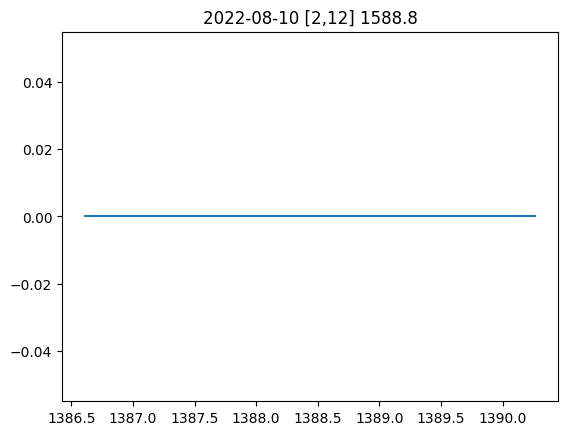

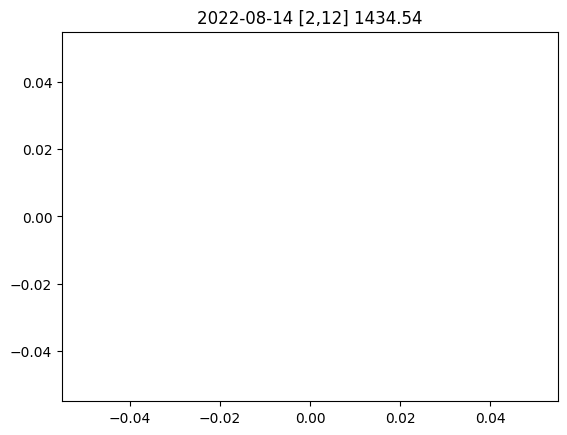

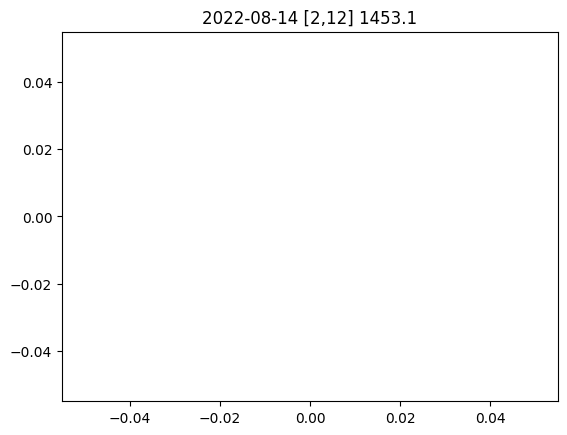

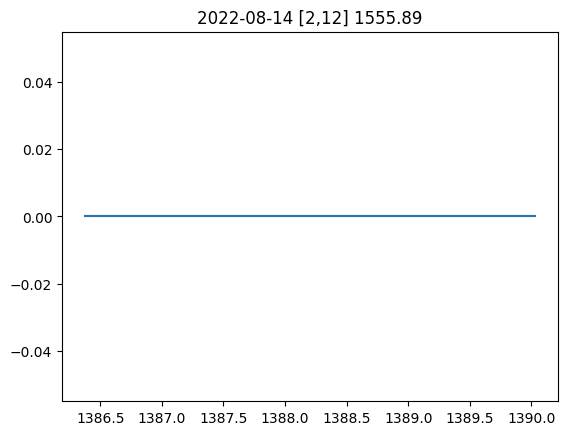

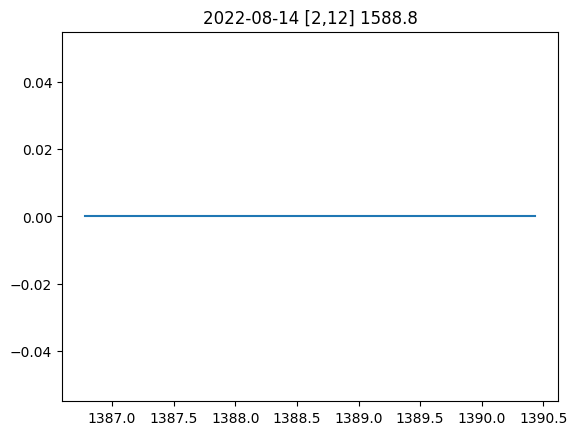

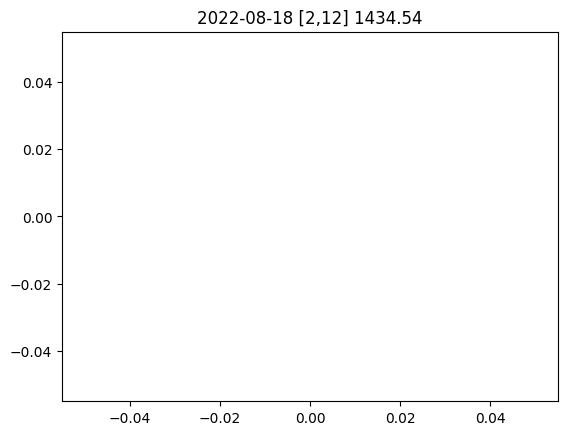

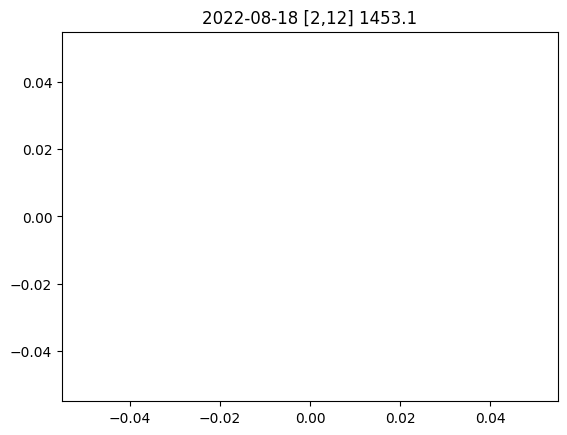

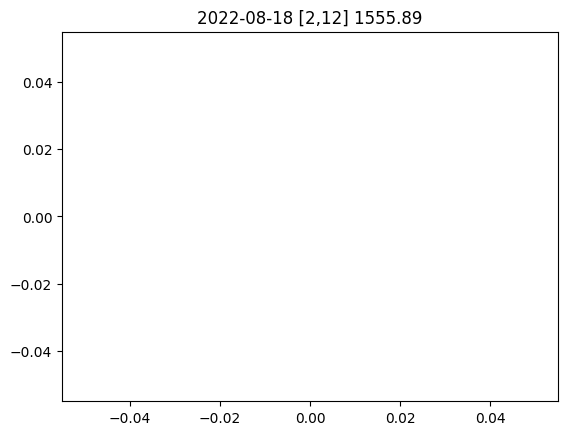

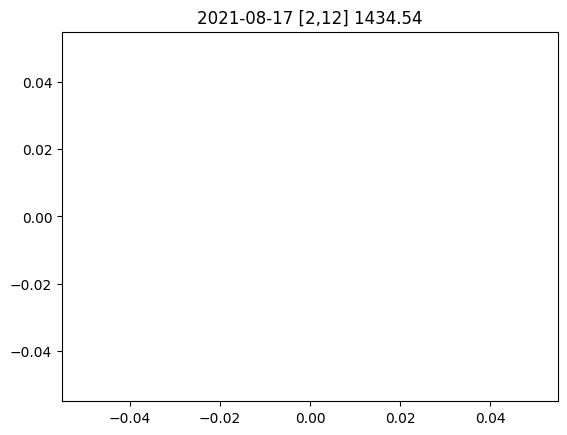

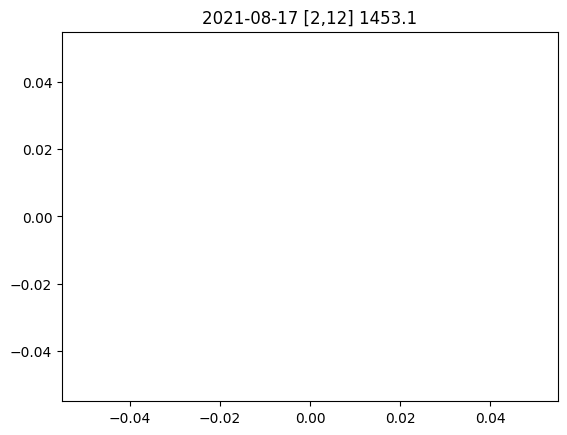

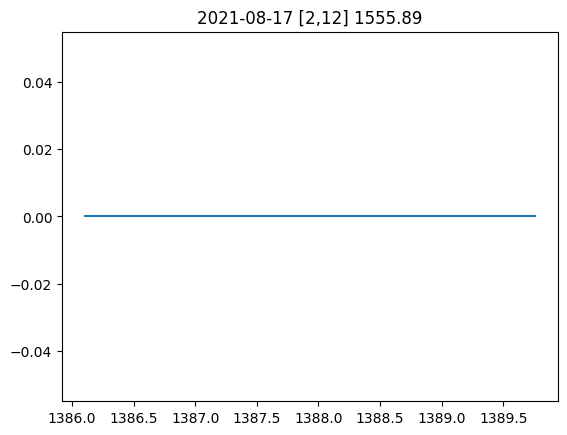

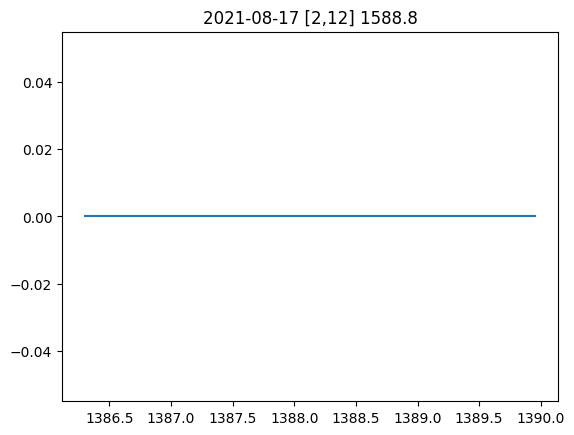

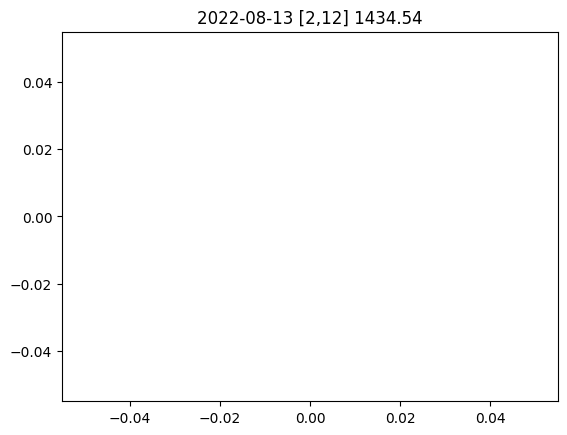

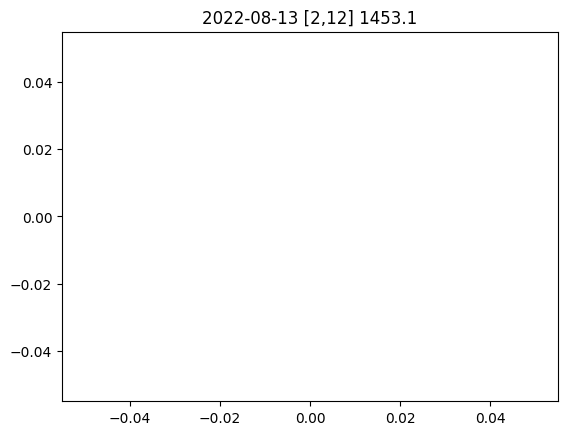

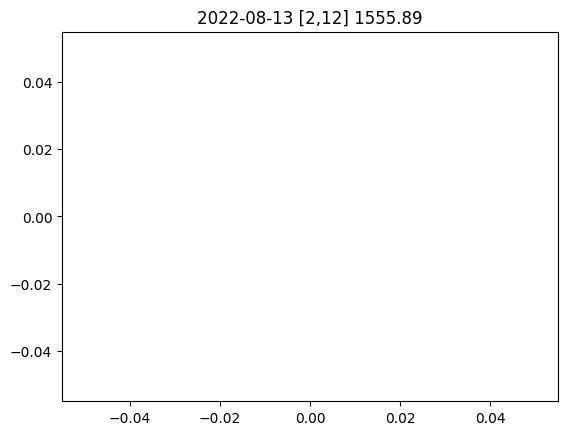

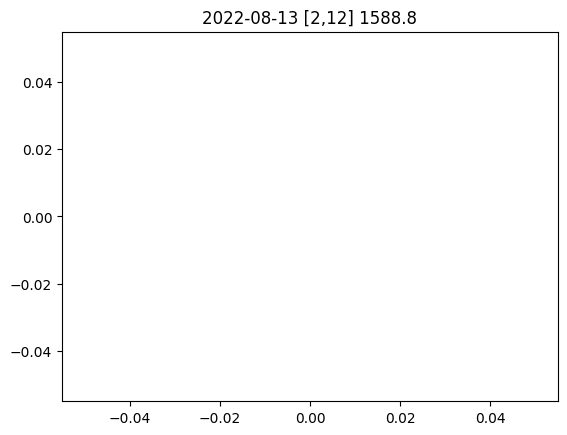

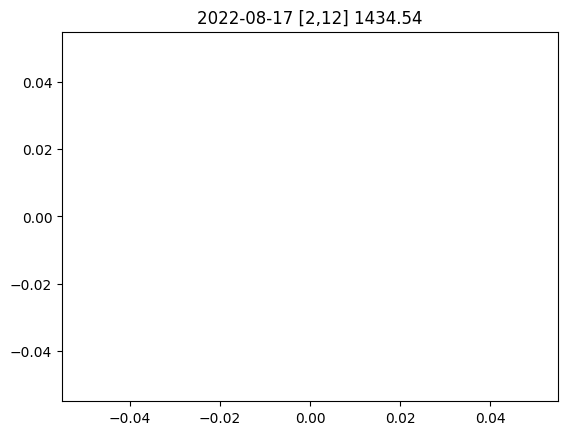

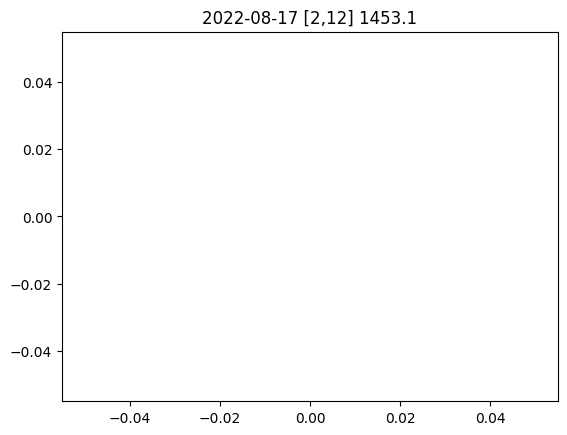

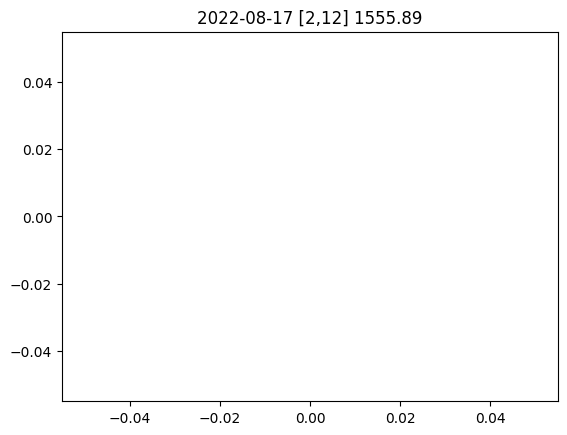

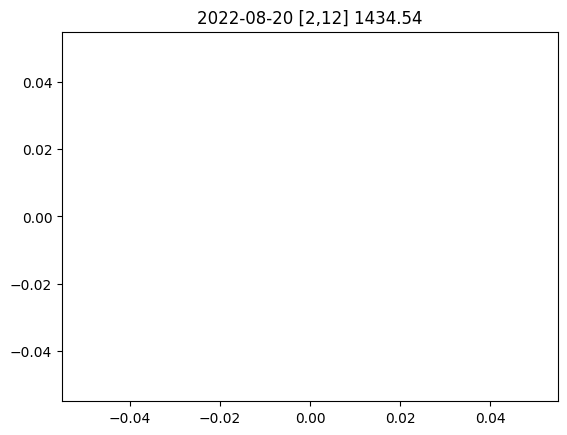

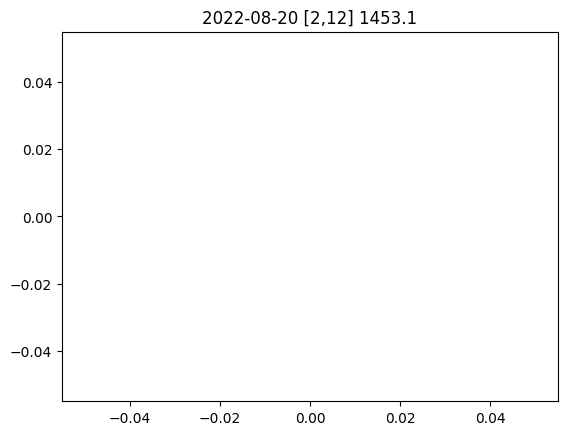

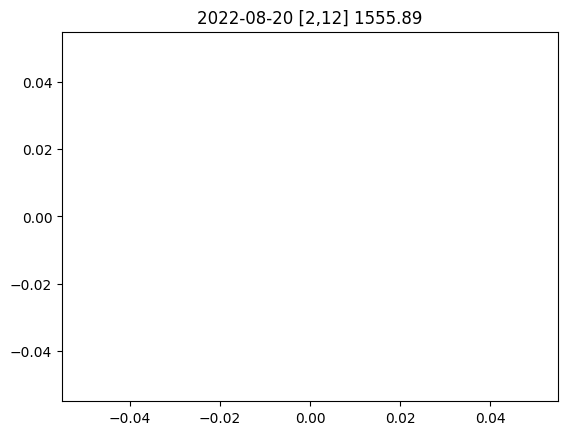

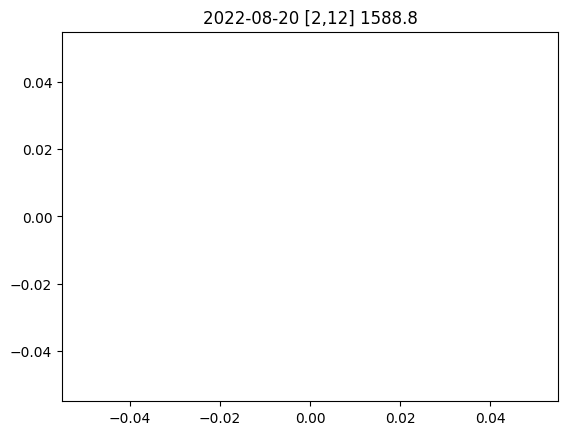

In [29]:
mask = line_df['transition']=='[2,12]'

for _, row in line_df[mask].iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.title(row['obsdate']+' '+row['transition']+' '+str(row['labline']))
    plt.show()

In [30]:
exclude_lines = {
    "[0,1]": {
        "dates": ["2022-08-11", "2022-08-24", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2011-07-20", "2012-02-28", "2012-02-28", "2021-08-16", "2022-08-14"],
        "wavelengths": [1460.17, 1521.59, 1521.59, 1398.95, 1460.17, 1521.59, 1398.95, 1521.59, 1398.95, 1521.59, 1521.59]
    },
    "[0,2]": {
        "dates": ["2022-06-16", "2022-08-11", "2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2022-08-10", "2022-08-13"],
        "wavelengths": [1525.15, 1463.83, 1525.15, 1402.65, 1463.83, 1525.15, 1402.65, 1525.15, 1525.15]
    },
    "[1,4]": {
        "dates": ["2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11"],
        "wavelengths": [1431.01, 1431.01, 1446.12, 1489.57, 1504.76]
    },
    "[1,7]": {
        "dates": ["All", "All", "2022-08-11", "2022-08-11", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2021-08-21", "2022-08-18"],
        "wavelengths": [1556.87, 1524.65, 1467.08, 1500.45, 1556.87, 1467.08, 1500.45, 1524.65, 1556.87, 1556.87, 1556.87, 1556.87]
    },
    "[2,12]": {
        'dates': ['2021-08-10', '2021-08-18', '2021-08-18', '2022-06-16', '2022-06-16', '2022-08-1', '2022-08-11', '2022-08-11', '2021-08-20', '2011-07-20', '2021-08-11', '2021-08-11', '2021-08-11', '2012-02-28', '2021-08-16', '2021-08-12', '2022-08-10', "All"],
        "wavelengths": [1453.10, 1555.89, 1588.8, 1453.1, 1555.89, 1453.1, 1555.89, 1588.8, 1555.89, 1588.8, 1453.1, 1555.89, 1588.8, 1555.89, 1453.1, 1555.89, 1453.1, 1434.54]
    }
}


In [31]:
# exclude bad/contaminated lines from coadding
bad_transitions = ['[3,0]', '[4,13]', '[3,13]', '[4,4]', '[2,15]', '[3,16]', '[4,0]']
bad_transitions_mask = ~line_df['transition'].isin(bad_transitions)
line_df_good = line_df[bad_transitions_mask]

contaminated = []
for transition in exclude_lines.keys():
    dates = exclude_lines[transition]['dates']
    lines_ex = exclude_lines[transition]['wavelengths']
    for d, w in zip(dates, lines_ex):
        if d == "All":
            exclude_idx = line_df_good.index[(line_df_good['transition']==transition)&(line_df_good['labline']==w)].tolist()
        else:
            exclude_idx = line_df_good.index[(line_df_good['transition']==transition)&(line_df_good['labline']==w)&(line_df_good['obsdate']==d)].tolist()
        contaminated.extend(exclude_idx)

line_df_good = line_df_good.drop(index=contaminated)

line_df_good

transition  labline     obsdate wavelength flux fluxerr
66       [0,2]  1402.65  2021-08-13         []   []      []
67       [0,2]  1463.83  2021-08-13         []   []      []
68       [0,2]  1525.15  2021-08-13         []   []      []
69       [0,2]  1463.83  2021-08-10         []   []      []
70       [0,2]  1525.15  2021-08-10         []   []      []
..         ...      ...         ...        ...  ...     ...
707      [0,3]  1407.29  2021-08-17         []   []      []
708      [0,3]  1468.39  2021-08-17         []   []      []
709      [0,3]  1468.39  2022-08-13         []   []      []
710      [0,3]  1468.39  2022-08-17         []   []      []
711      [0,3]  1468.39  2022-08-20         []   []      []

[369 rows x 6 columns]

# Coadd progressions

In [22]:
#coadd all spectral lines in the same progression for better SNR
prog_df = all_spectra.coaddwave(line_df_good, columns=['obsdate', 'transition'], velocity=True)
prog_df

ValueError: array of sample points is empty

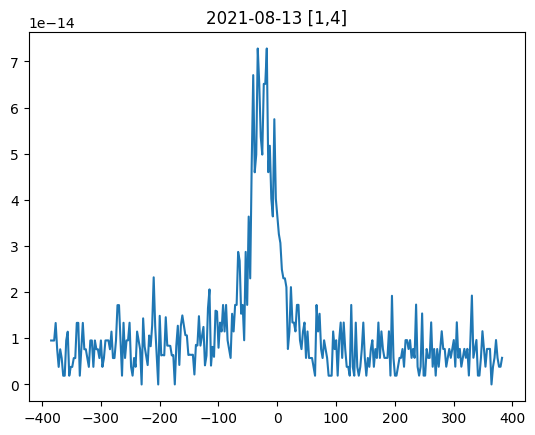

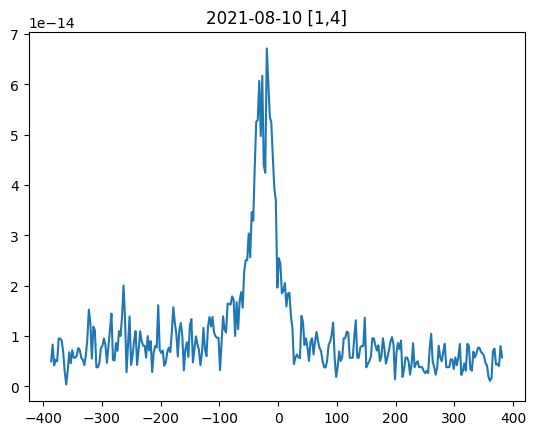

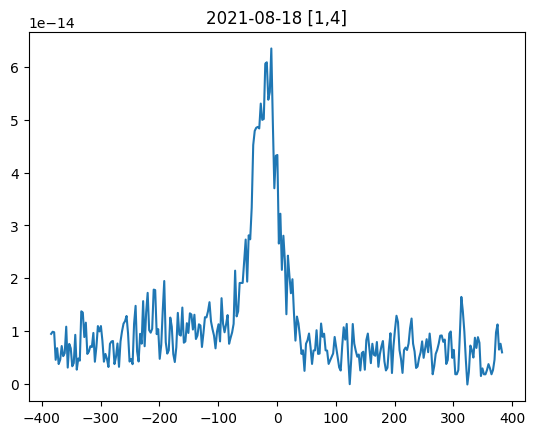

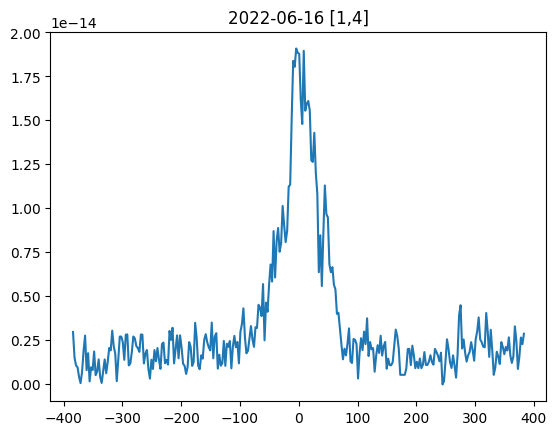

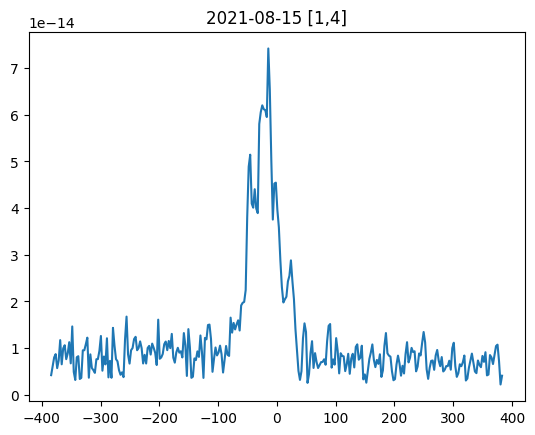

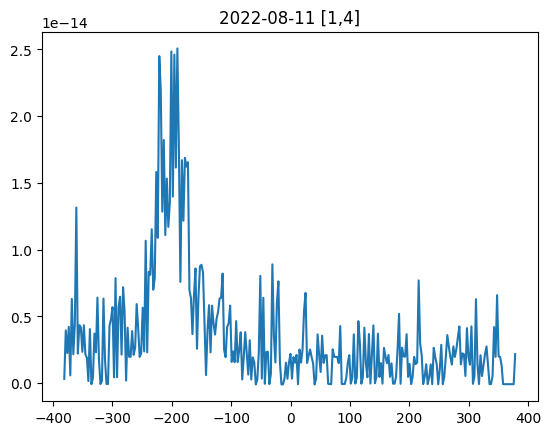

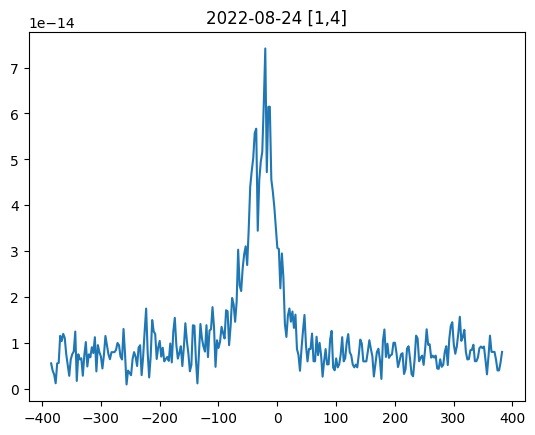

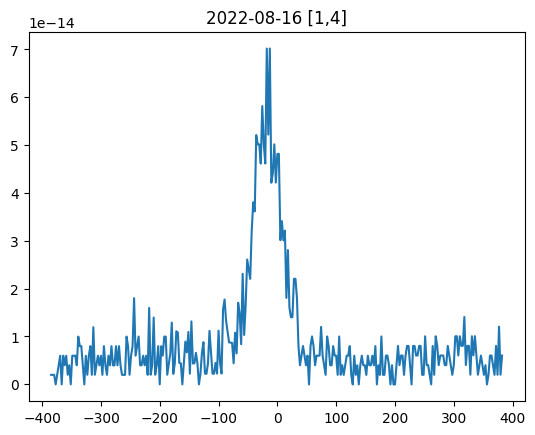

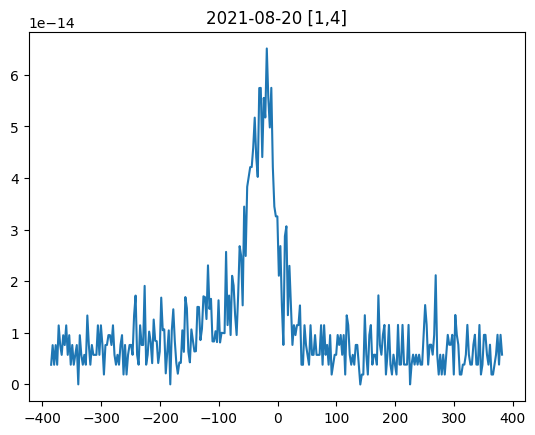

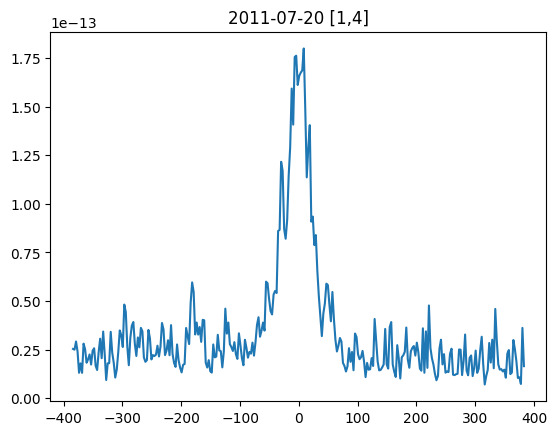

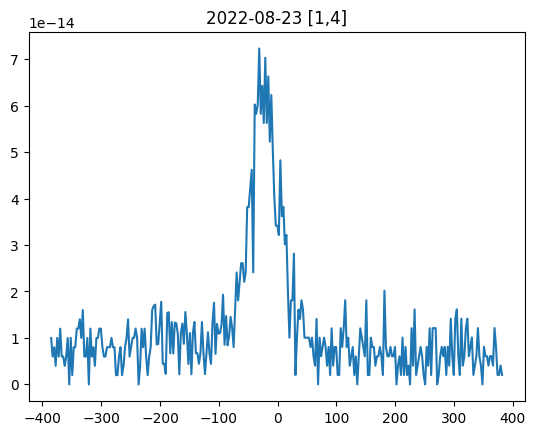

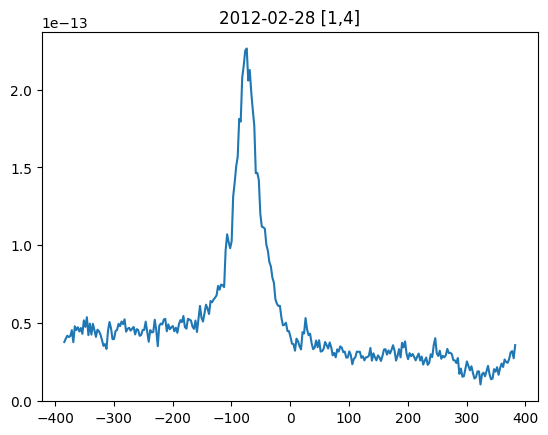

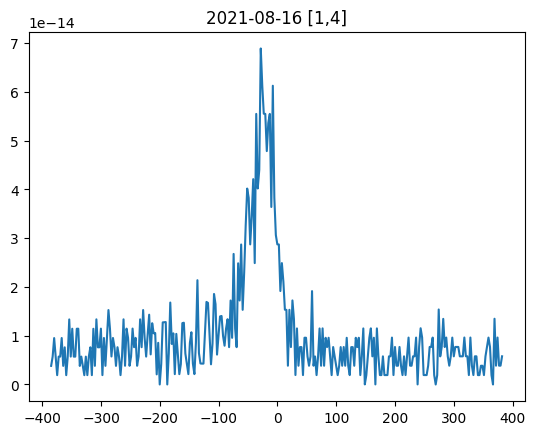

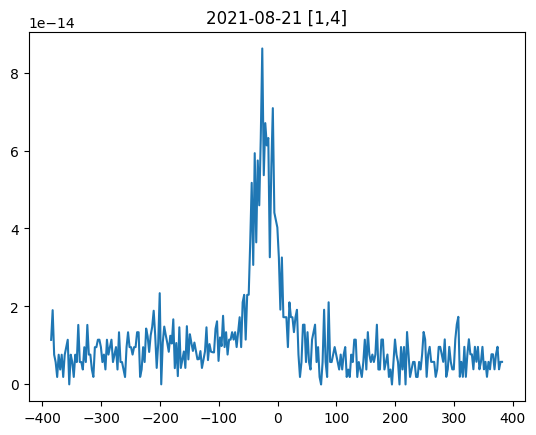

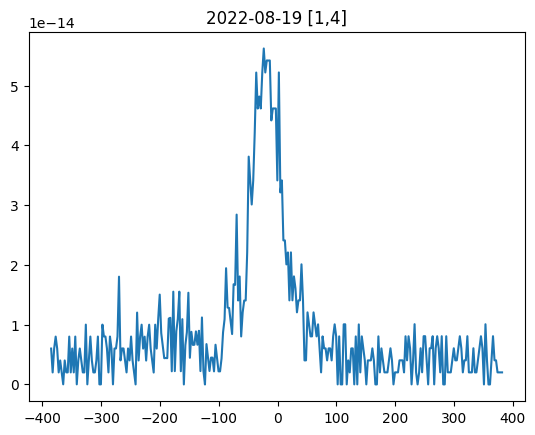

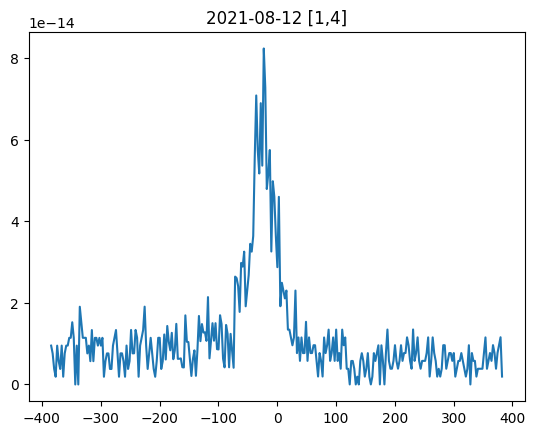

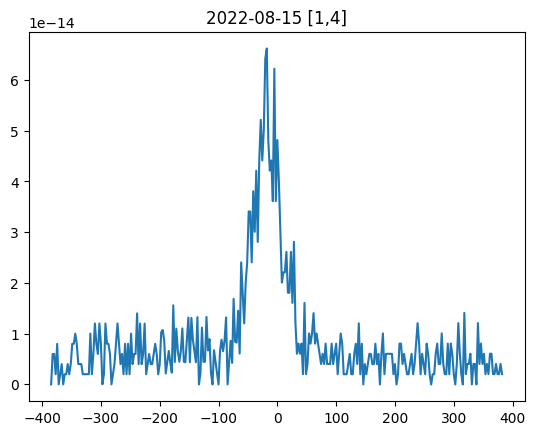

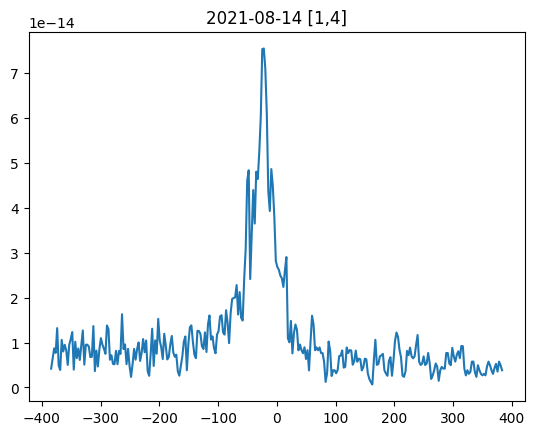

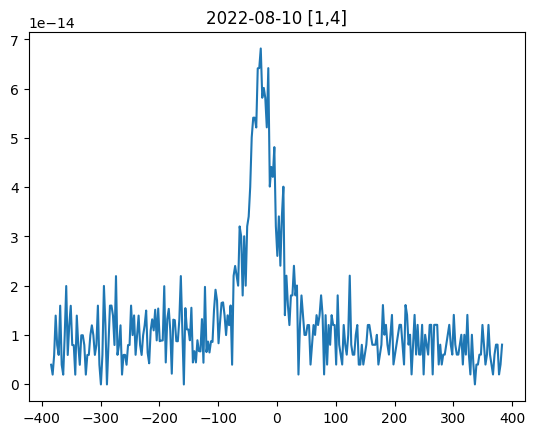

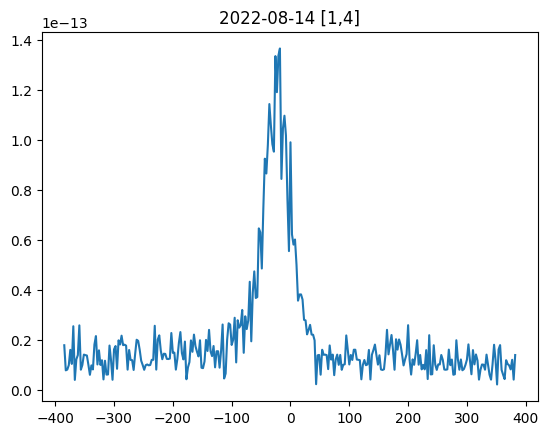

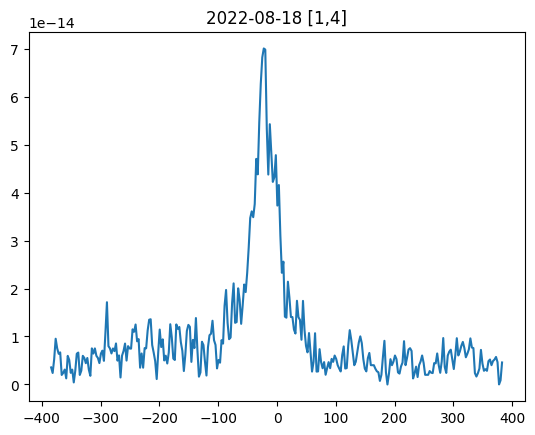

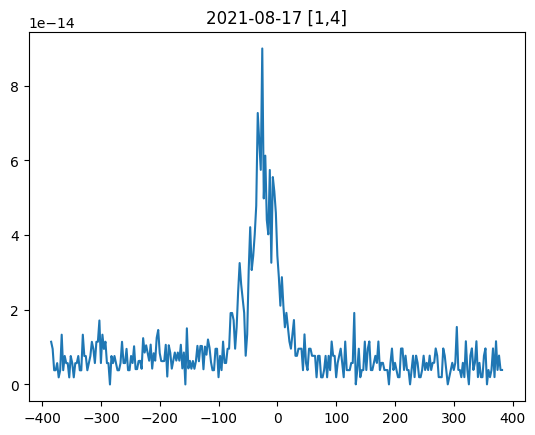

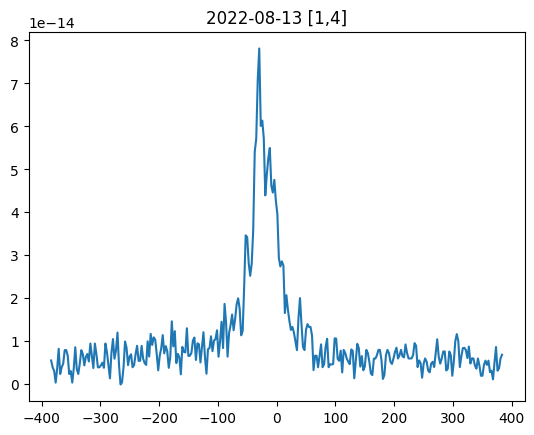

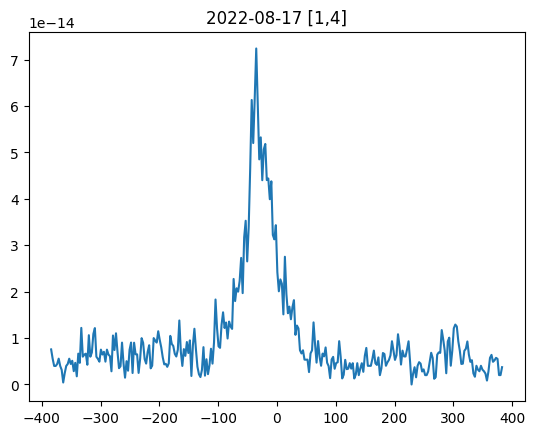

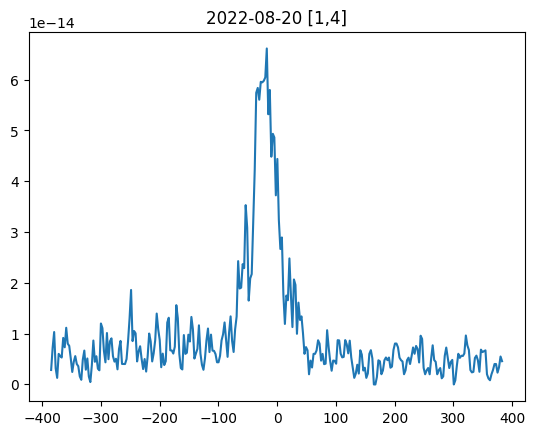

In [12]:
mask = prog_df['transition']=='[1,4]'

for _, row in prog_df[mask].iterrows():
    plt.plot(row['velocity'], row['flux'])
    plt.title(row['obsdate']+' '+row['transition'])
    plt.show()